In [21]:
from cleverhans.torch.attacks.noise import noise
from cleverhans.torch.attacks.hop_skip_jump_attack import hop_skip_jump_attack
from cleverhans.torch.attacks.spsa import spsa
from cleverhans.torch.attacks.carlini_wagner_l2 import carlini_wagner_l2
from cleverhans.torch.attacks.sparse_l1_descent import sparse_l1_descent

In [37]:
#https://github.com/nhamlv-55/CFI_NNs/blob/master/MNIST_toy/Experiment-Feb28-xujie-Copy1.ipynb

from models import FeedforwardNeuralNetModel, TinyCNN, PatternClassifier, NewTinyCNN
import regularizer_losts as rl
from torchvision import datasets, transforms
from torch import optim
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import copy
import utils as CFI_utils
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
#from frozendict import frozendict
from datetime import datetime
import seaborn as sn
import pandas as pd


from absl import app, flags
from easydict import EasyDict
import torch.nn as nn

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent,
)



%matplotlib inline

import seaborn as sns
colors = sns.color_palette("tab10")

#Logging stuffs
import logging
import sys
# Create logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Create STDERR handler
handler = logging.StreamHandler(sys.stderr)
# ch.setLevel(logging.DEBUG)

# Create formatter and add it to the handler
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Set STDERR handler as the only handler 
logger.handlers = [handler]

#configs
epochs = 10
batch_size = 1000
test_batch_size = 10000
stable_batch_size = 60000
use_cuda = torch.cuda.is_available()
print(use_cuda)

lr = 0.01
log_interval = 100

#torch specific configs
torch.manual_seed(1)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}

test_kwargs = {'batch_size': test_batch_size}
stable_kwargs = {'batch_size': stable_batch_size}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
    stable_kwargs.update(cuda_kwargs)
class Shift:
    def __init__(self, shift = 0):
        print("alive")
        self.shift = shift

    def __call__(self, arr):
        print("running")
        #print(arr)
        return arr
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"
    
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


transform = transforms.Compose([
    transforms.ToTensor(),
   
    transforms.Normalize((0.1307,), (0.3081,))
   
  
])

def shift_and_roll(arr : torch.Tensor, x : int , y : int) -> torch.Tensor:
    return torch.roll(arr, shifts = (x,y), dims = (0,1)) #indexing
def shift(arr : torch.Tensor, x : int , y : int) -> torch.Tensor:

    pad = [0,0,0,0]
    x_start = 0
    x_end = 0
    y_start = 0
    y_end = 0
    if x >= 0:
        pad[0] = x
        x_start = 0
        x_end = 28
    else:
        pad[1] = abs(x)
        x_start = -28
         
         
        
         
    
    if y >= 0:
        pad[2] = y
        y_start = 0
        y_end = 28
    else:
        pad[3] = abs(y)
        y_start= -28
        print("ys is {}".format(y_start))
    

    padder = torch.nn.ZeroPad2d(tuple(pad))
  
    result = padder(arr)

    if y < 0:
        y_end = result.shape[0]
    if x < 0:
        x_end = result.shape[1]
    
    return result[y_start:y_end, x_start:x_end]

def noisify(arr : torch.Tensor , distribution : torch.distributions.Distribution) -> torch.Tensor: #randomly add noise
   
    #print(distribution.sample(arr.size()).shape\\)
    #print(torch.reshape(distribution.sample(arr.size()), (28,28)).shape)
   
    noise = torch.reshape(distribution.sample(arr.size()), (arr.shape))
    return arr + noise
transform = transforms.Compose([
    transforms.ToTensor(),
   
    transforms.Normalize((0.1307,), (0.3081,))
])


True


In [2]:
def transform_dataset(dataset):
    '''
    DO A STATE CHANGE
    '''
    shift_x = 1
    shift_y = 0
    mu = 1
    sigma = 1
    do_shift = False
    do_noisfy = True
    modification_string = "base"
    if do_shift:
        modification_string += " -shift {} {} - ".format(shift_x, shift_y)
    if do_noisfy:
        modification_string += " -noise added using gaussian using mean {} and stddev {}- ".format(mu, sigma)
    for i in range(dataset.data.shape[0]):
        if do_shift:
            dataset.data[i,:,:] = shift(dataset.data[i,:,:],shift_x, shift_y)
        
        if do_noisfy:
            gaussian = torch.distributions.Normal(loc = mu, scale = sigma)# loc = mu, scale = stddev

            dataset.data[i,:,:] = noisify(dataset.data[i,:,:], gaussian)
    return modification_string

## Train/Load model


In [3]:
def check_gradient(grad, label, last_sorted_grads, plot = False):
    logging.info("CHECKING GRADIENT FOR LABEL {}".format(label))
    sum_abs_grad = np.sum(abs(grad[label]), axis = 0)
    
    current_sorted_grad = (-sum_abs_grad).argsort()
    
#     if len(last_sorted_grads[label]) > 0:
#         for k in [100, 200, 300, 400]:
#             prev_top_k = set(last_sorted_grads[label][-1][:k])
#             current_top_k = set(current_sorted_grad[:k])
#             intersect = prev_top_k.intersection(current_top_k)
#             logging.info('k = {}. How many top Gradients are stable since last epoch?: {}'.format(k, len(intersect)))
        
    for k in [0, 9, 99, 199]:    
        logging.debug('{}th biggest gradient = {}'.format(k, np.sort(-sum_abs_grad)[k]))
    if plot:
        fig = plt.figure(figsize=(30, 1))
        plt.bar(range(sum_abs_grad.shape[0]), sum_abs_grad)
        plt.show()
        print(sum_abs_grad.max(), sum_abs_grad.argmax(), sum_abs_grad.min())

    return current_sorted_grad



#init stuffs
LOAD = True
# LOADPATH = 'FFN19-17-24'
LOADPATH = 'FFN18_28_21'
# LOADPATH = 'TinyCNN14-28-29'

LAST_N_EPOCHS = 10

dataset1 = datasets.MNIST('./data', train=True, download=False,
                          transform=transform)
dataset2 = datasets.MNIST('./data', train=False, download=False,
                          transform=transform)


#transform_dataset(dataset1)
#modification_string = transform_dataset(dataset2)
modification_string = ""
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
# model = TinyCNN().to(device)

if LOAD:
    model.load_state_dict(torch.load(LOADPATH))
else:

    epochs = 10
    optimizer = optim.Adadelta(model.parameters(), lr=lr)

    scheduler = StepLR(optimizer, step_size=1, gamma = 0.7)
    last_sorted_grads = defaultdict(list)
    
    all_rows = []
    
    for epoch in tqdm(range(1, epochs + 1)):
        model.register_gradient()
        model.train()
        target_log  = None # need to record the label to match with the gradient later
        for data, target in train_loader:
            target_log = np.concatenate((target_log, target), axis = 0) if target_log is not None else target
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data.float())
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
        CFI_utils.test(model, device, test_loader)
#         scheduler.step()
        grad = CFI_utils.get_grad_each_label(model.gradient_log, 
                                      target_log = target_log, 
                                      layers = ['fc1', 'fc2', 'fc3', 'fc4'], 
#                                       layers = ['conv1', 'conv2','fc1', 'fc2'],
                                      labels = range(10))
        torch.save(model.state_dict(), model.model_savename())
        
        row_data = []
        for label in range(10):
            r = []
            logging.info("After {} epoch:".format(epoch))
            last_sorted_grads[label].append(check_gradient(grad, label, last_sorted_grads))
            
            
            if epoch >= LAST_N_EPOCHS:
                for k in [100, 200, 300, 400]:
                    all_top_k = [set(sorted_grad[:k]) for sorted_grad in last_sorted_grads[label][-LAST_N_EPOCHS:]]
                    intersect = set.intersection(*all_top_k)
                    logging.info('k = {}. How many top Gradients are stable among all last {} epochs?: {}'.format(k, LAST_N_EPOCHS, len(intersect)))

                    

with torch.no_grad():
    total = 0
    correct = 0
    for data, target in dataset2:
        data_extend = data[None, :]
#         if int(torch.argmax(model.cpu()(data.cpu()), dim = 1)) == target:
        if int(torch.argmax(model.cuda()(data_extend.cuda()), dim = 1)) == target:
            correct += 1
        total+=1
    "accuracy {}".format( correct/total)
    modification_string += " -accuracy {}-".format( correct/total)
    print(modification_string)

 -accuracy 0.9042-


#### Compute all patterns in the training set, and put them into corresponding labels

In [4]:
class Patterns:
    def __init__(self, model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, labels, layers):
        self._model = model
        self.label2patterns = {}
        self.label2idx = {}
        self._labels = labels
        self._layers = layers
        self._dataloader = dataloader
        self._populate()
        
    def _populate(self):
        
        label2patterns = {}
        label2idx = {}
        for label in self._labels:
            patterns = []
            filter_ids = []
            
            for data, target in self._dataloader:
                
                flter = np.where(target == label)
                filter_ids.append(flter)
                data = data[flter]
                logging.debug(data.shape[0])
                pattern = self._model.get_pattern(data, layers, device, flatten = True)
                logging.debug(pattern.shape)
                patterns.append(pattern)

            patterns = np.squeeze(np.concatenate(patterns, axis = 0))
            filter_ids = np.squeeze(np.concatenate(filter_ids, axis = 0))
            label2patterns[label] = patterns
            label2idx[label] = filter_ids
            
            logging.info(patterns.shape)
        
        #freeze
        self.label2patterns = dict(label2patterns)
        self.label2idx = dict(label2idx)
        
    def apply_filter(self, f):
        pass
    
    def unique():
        pass
    
    def query_pattern():
        pass
    
    

layers = ['fc1', 'fc2', 'fc3', 'fc4']
# layers = ['conv1', 'conv2','fc1', 'fc2']

labels = range(10)
K = 25
stable_loader = torch.utils.data.DataLoader(dataset1, **stable_kwargs)

all_patterns = Patterns(model = model,
                        dataloader = stable_loader,
                        labels = labels,
                        layers = layers)
all_test_patterns = Patterns(model = model,
                        dataloader = test_loader,
                        labels = labels,
                        layers = layers)



root - INFO - (5923, 458)
root - INFO - (6742, 458)
root - INFO - (5958, 458)
root - INFO - (6131, 458)
root - INFO - (5842, 458)
root - INFO - (5421, 458)
root - INFO - (5918, 458)
root - INFO - (6265, 458)
root - INFO - (5851, 458)
root - INFO - (5949, 458)
root - INFO - (980, 458)
root - INFO - (1135, 458)
root - INFO - (1032, 458)
root - INFO - (1010, 458)
root - INFO - (982, 458)
root - INFO - (892, 458)
root - INFO - (958, 458)
root - INFO - (1028, 458)
root - INFO - (974, 458)
root - INFO - (1009, 458)


In [5]:
#we can only study gradient if the model is trained
# FIXME: should save gradient into a pickle as well
if not LOAD:
    for K in [25, 50, 100]:
        print("K=", K)
        row = []
        row.append(str(K))
        for label in labels:
            #construct the stable gradients 
            all_top_k = [set(sorted_grad[:K]) for sorted_grad in last_sorted_grads[label][-LAST_N_EPOCHS:]]
            intersect = set.intersection(*all_top_k)
            stable_grad = np.array(sorted(list(intersect)))
            print("There are {} stable grad in top K".format(len(stable_grad)))
            print(stable_grad)

            logging.info(all_patterns[label].shape)
            print("LABEL:", label)
            print("how many unique paths in the full pattern?", np.unique(all_patterns[label], axis = 0).shape)
            print("how many unique paths in the filtered pattern?", np.unique(all_patterns[label][:, stable_grad ], axis = 0).shape)
            print("how many unique paths in the randomly filtered pattern?", 
                  np.unique(patterns[:, 
                                     np.random.choice(458, len(stable_grad), replace = False) ], axis = 0).shape)
            row.append("|".join([str(len(stable_grad)),
                                 str(np.unique(all_patterns[label], axis = 0).shape[0]),
                                 str(np.unique(all_patterns[label][:, stable_grad ], axis = 0).shape[0]),
                                 str(np.unique(all_patterns[label][:, np.random.choice(458, len(stable_grad), replace = False) ], axis = 0).shape[0])
                                ]))
        all_rows.append(",".join(row)+"\n")

    with open("gradient_exp_log_2.csv", "w") as f:
        f.write("K,"+",".join([str(l) for l in labels]) + "\n")
        f.writelines(all_rows)

In [6]:
import json

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.bool_):
            return int(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)
    


all_stable_relus = []

all_alpha_patterns = {"model": LOADPATH}

write_log = True
if write_log:
    ReLU_exp_log = open("relu_exp_log{}.csv".format(datetime.now().strftime("%H-%M-%S")), "w")
    ReLU_exp_json = open("relu_exp_data{}.json".format(datetime.now().strftime("%H-%M-%S")), "w")
    ReLU_exp_log.write("Epsilon,Label,NumStableReLU,NumUniqueAP,Alpha Pattern Cover\n")



# for epsilon in [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]:
epsilon_to_patterns = dict()
for epsilon in [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]:
    alpha_patterns = {}
    label_to_most_common_pattern = dict()
    for label in all_patterns.label2patterns:
#     for label in [0,2,8]:
        patterns = all_patterns.label2patterns[label]
        print(patterns.shape)

        occuring_patterns = patterns.tolist() #make patterns into list of lists first dim is each example, second dim is the pattern
        most_common_pattern = max(occuring_patterns, key =  lambda x :occuring_patterns.count(x)) #argmax the count of each pattern

        #print("most common pattern: {}".format(most_common_pattern) )
        
        pattern_indices = list(filter( lambda x : most_common_pattern[x] , range(len(most_common_pattern))   ))#get true indices     
        #print("pattern_indices: {}".format(pattern_indices))
        label_to_most_common_pattern[label] = (pattern_indices,most_common_pattern)
        relu_sum = np.sum(patterns, axis = 0).squeeze()
        
        print("threshold: ", epsilon*patterns.shape[0], (1-epsilon)*patterns.shape[0])
        
#         print("relu_sum, layer-1 ", relu_sum[:256])
#         print("relu_sum, layer-2 ", relu_sum[256:384])
#         print("relu_sum, layer-3 ", relu_sum[384:448])
        print("relu_sum, prediction", relu_sum[448:458])
#         print("relu_sum", relu_sum[-10:])
        
        non_active_neurons = np.where(relu_sum<=epsilon*patterns.shape[0])
        active_neurons = np.where(relu_sum>=(1-epsilon)*patterns.shape[0])
        print("non active neurons: ", non_active_neurons)
        print("active neurons: ", active_neurons)

        stable_idx = np.concatenate([np.where(relu_sum<=epsilon*patterns.shape[0]), 
                                     np.where(relu_sum>=(1-epsilon)*patterns.shape[0])],
                                    axis = 1
                                    ).squeeze()
        neuro_idx = patterns.shape[1] - 10 + label
        if neuro_idx not in stable_idx:
            print(f"WARN: neuro_idx = {neuro_idx} for label {label} is not stable, let's include it anyway")
            stable_idx = np.append(stable_idx, neuro_idx)
        stable_idx = sorted(stable_idx) #sort the indices of the stable ReLUs. 
        unique_patterns, freq = np.unique(patterns[:, stable_idx ], axis = 0, return_counts=True)
        alpha_p = unique_patterns[np.argmax(freq)]
        print("unique patterns:", unique_patterns)
        print()
        print("Label is ", label)
        print("Stable ReLUs", stable_idx)
        print("how many unique paths in the filtered pattern?", unique_patterns.shape)
        print("their freq\n", freq, freq.shape)
#         print("most prominent pattern", np.argmax(freq), alpha_p)
#         print("alpha_p is ", alpha_p)


        assert(len(stable_idx) == alpha_p.shape[-1])
        assert(freq.shape[0]==unique_patterns.shape[0])
#         alpha_patterns[label] = (stable_idx, tuple(alpha_p))
#         alpha_patterns[label] = {"stable_idx": stable_idx,
#                                 "alpha_pattern": alpha_p,
#                                 "alpha_pattern_coverage": freq.max()/freq.sum(),
#                                 "pattern_frequency": freq}
        alpha_patterns[label] = {"stable_idx": stable_idx,
                                 "active_neurons": active_neurons[0],
                                 "non_active_neurons": non_active_neurons[0],
                                "alpha_pattern": alpha_p,
                                "alpha_pattern_coverage": freq.max()/freq.sum(),
                                "pattern_frequency": freq}
    
#         print("pattern frequency:", freq)
        print("primary pattern coverage: ", freq.max()/freq.sum(),)

        if write_log:
            ReLU_exp_log.write("{},{},{},{},{}\n".format(epsilon, label, len(stable_idx), unique_patterns.shape[0], freq.max()/freq.sum()))
    all_alpha_patterns[epsilon] = alpha_patterns
    epsilon_to_patterns[epsilon] = label_to_most_common_pattern
json.dump(epsilon_to_patterns, open("most_common_patterns{}.json".format(datetime.now().strftime("%H-%M-%S")), "w")) 
    
if write_log:
    ReLU_exp_log.close()
    json.dump(all_alpha_patterns, fp = ReLU_exp_json, indent=2, cls=NpEncoder)
    ReLU_exp_json.close()

(5923, 458)
threshold:  0.5923 5922.4077
relu_sum, prediction [5685    0   29   15   11   77   48   11   43    4]
non active neurons:  (array([257, 267, 288, 338, 343, 374, 375, 392, 401, 403, 414, 418, 449],
      dtype=int64),)
active neurons:  (array([ 19,  70, 142, 238, 258, 259, 260, 265, 275, 285, 287, 295, 302,
       307, 323, 329, 339, 340, 346, 347, 349, 352, 360, 365, 369, 380,
       396, 406, 417, 420, 423, 424, 426, 429, 434], dtype=int64),)
WARN: neuro_idx = 448 for label 0 is not stable, let's include it anyway
unique patterns: [[ True  True  True  True False  True  True  True  True False  True  True
   True False  True  True  True  True  True False  True  True False  True
   True  True  True  True  True  True False False  True False  True False
  False  True False  True False  True  True  True  True  True  True False
  False]
 [ True  True  True  True False  True  True  True  True False  True  True
   True False  True  True  True  True  True False  True  True False  Tr

threshold:  0.5918 5917.4082
relu_sum, prediction [  57   31   44    1   68   85 5606    1   25    0]
non active neurons:  (array([257, 267, 288, 325, 338, 343, 345, 374, 375, 392, 401, 403, 411,
       414, 418, 444, 457], dtype=int64),)
active neurons:  (array([ 39,  58, 142, 145, 179, 196, 207, 210, 220, 238, 253, 258, 259,
       273, 275, 285, 295, 297, 299, 302, 307, 310, 314, 315, 316, 321,
       323, 329, 333, 336, 339, 340, 346, 347, 349, 356, 357, 358, 360,
       365, 366, 369, 371, 378, 379, 380, 394, 395, 404, 405, 406, 409,
       410, 420, 423, 431, 434, 441], dtype=int64),)
WARN: neuro_idx = 454 for label 6 is not stable, let's include it anyway
unique patterns: [[ True  True  True  True  True  True  True  True  True  True  True False
   True  True False  True  True  True False  True  True  True  True  True
   True  True  True  True  True  True False  True  True  True False  True
   True False False  True  True  True  True  True  True  True  True  True
   True  True Fa

threshold:  3.371 6738.629000000001
relu_sum, prediction [   1 6519   35   27   10   28    8   22   88    4]
non active neurons:  (array([257, 267, 319, 325, 326, 338, 343, 345, 374, 375, 386, 392, 401,
       403, 411, 414, 418, 444, 448], dtype=int64),)
active neurons:  (array([  1,   6,  12,  13,  17,  26,  31,  33,  39,  49,  58,  65,  66,
        75,  87,  91,  96,  97,  98,  99, 112, 145, 157, 158, 162, 167,
       176, 180, 189, 194, 196, 207, 220, 239, 249, 256, 258, 259, 260,
       268, 270, 271, 272, 273, 275, 277, 284, 290, 295, 297, 310, 312,
       314, 315, 317, 318, 321, 323, 328, 329, 333, 336, 339, 341, 346,
       356, 357, 358, 363, 364, 366, 368, 369, 371, 377, 378, 379, 380,
       387, 389, 390, 394, 399, 400, 404, 408, 409, 416, 419, 420, 424,
       428, 431, 433, 435, 438, 441, 443], dtype=int64),)
WARN: neuro_idx = 449 for label 1 is not stable, let's include it anyway
unique patterns: [[False False  True ... False False False]
 [ True False  True ... False F

threshold:  2.9210000000000003 5839.079000000001
relu_sum, prediction [  14   22   33    0 5380   12   86    9   42  244]
non active neurons:  (array([257, 267, 288, 319, 325, 343, 345, 372, 374, 375, 386, 392, 401,
       403, 411, 414, 418, 444, 451], dtype=int64),)
active neurons:  (array([ 54,  55,  58,  66,  84, 115, 129, 143, 145, 155, 196, 220, 223,
       228, 256, 258, 261, 273, 275, 285, 286, 295, 296, 298, 299, 302,
       306, 307, 310, 314, 316, 321, 323, 333, 336, 339, 341, 346, 349,
       351, 356, 357, 358, 360, 377, 378, 379, 394, 395, 404, 405, 407,
       409, 417, 420, 422, 423, 425, 426, 431, 436, 441], dtype=int64),)
WARN: neuro_idx = 452 for label 4 is not stable, let's include it anyway
unique patterns: [[False False  True ... False False False]
 [False  True  True ... False False False]
 [ True False  True ... False False False]
 ...
 [ True  True  True ... False False  True]
 [ True  True  True ... False False  True]
 [ True  True  True ... False False  True]

threshold:  2.9745 5946.025500000001
relu_sum, prediction [  43   21   22   76  249   43   10  247   72 5166]
non active neurons:  (array([257, 267, 343, 345, 372, 374, 375, 392, 401, 403, 411, 414, 418],
      dtype=int64),)
active neurons:  (array([ 12,  54,  58,  65,  66,  87,  98, 112, 115, 138, 143, 155, 189,
       196, 220, 223, 258, 259, 273, 275, 277, 282, 283, 285, 286, 295,
       298, 299, 306, 307, 308, 314, 321, 323, 329, 333, 334, 336, 339,
       341, 346, 349, 351, 359, 360, 367, 369, 377, 380, 389, 404, 405,
       407, 417, 422, 426, 436], dtype=int64),)
WARN: neuro_idx = 457 for label 9 is not stable, let's include it anyway
unique patterns: [[False False  True ...  True  True False]
 [ True  True  True ...  True  True False]
 [ True  True  True ...  True  True False]
 ...
 [ True  True  True ...  True  True False]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True False]]

Label is  9
Stable ReLUs [12, 54, 58, 65, 66, 87, 98, 112, 115, 1

threshold:  5.8420000000000005 5836.158
relu_sum, prediction [  14   22   33    0 5380   12   86    9   42  244]
non active neurons:  (array([257, 267, 288, 319, 325, 326, 343, 345, 372, 374, 375, 386, 392,
       401, 403, 411, 414, 418, 444, 451], dtype=int64),)
active neurons:  (array([ 13,  51,  54,  55,  58,  65,  66,  84,  98, 107, 115, 129, 143,
       145, 155, 179, 196, 198, 200, 219, 220, 223, 228, 248, 256, 258,
       261, 273, 275, 277, 285, 286, 295, 296, 298, 299, 302, 306, 307,
       308, 310, 314, 316, 321, 323, 329, 333, 334, 336, 339, 340, 341,
       346, 347, 349, 351, 353, 356, 357, 358, 360, 361, 369, 377, 378,
       379, 394, 395, 397, 404, 405, 407, 409, 417, 419, 420, 422, 423,
       425, 426, 431, 436, 441], dtype=int64),)
WARN: neuro_idx = 452 for label 4 is not stable, let's include it anyway
unique patterns: [[False  True  True ... False False False]
 [False  True  True ... False False False]
 [ True False False ... False False False]
 ...
 [ True  True

threshold:  5.949 5943.051
relu_sum, prediction [  43   21   22   76  249   43   10  247   72 5166]
non active neurons:  (array([257, 267, 288, 343, 345, 372, 374, 375, 386, 392, 401, 403, 411,
       414, 418], dtype=int64),)
active neurons:  (array([  8,  12,  54,  55,  58,  65,  66,  87,  96,  98, 107, 112, 115,
       129, 138, 143, 155, 170, 189, 196, 201, 220, 223, 229, 258, 259,
       264, 273, 275, 277, 282, 283, 285, 286, 295, 298, 299, 306, 307,
       308, 312, 314, 321, 323, 329, 330, 332, 333, 334, 336, 339, 341,
       344, 346, 349, 351, 357, 358, 359, 360, 365, 367, 369, 377, 380,
       389, 391, 395, 404, 405, 407, 417, 422, 426, 431, 434, 436, 439,
       442], dtype=int64),)
WARN: neuro_idx = 457 for label 9 is not stable, let's include it anyway
unique patterns: [[False  True  True ...  True  True False]
 [False  True  True ...  True  True  True]
 [ True False False ... False False False]
 ...
 [ True  True  True ...  True  True False]
 [ True  True  True ...  Tru

threshold:  29.79 5928.21
relu_sum, prediction [  72  103 5157  106  116   22  126   98  127   31]
non active neurons:  (array([257, 267, 288, 305, 319, 325, 326, 343, 345, 372, 374, 375, 385,
       386, 392, 401, 403, 411, 414, 418, 444, 453], dtype=int64),)
active neurons:  (array([ 12,  17,  30,  39,  47,  58,  65,  75,  76,  97,  99, 112, 142,
       143, 145, 179, 180, 194, 196, 202, 214, 220, 242, 249, 258, 259,
       260, 270, 271, 273, 275, 277, 283, 286, 290, 293, 295, 297, 299,
       302, 307, 310, 314, 315, 321, 323, 329, 333, 339, 346, 347, 352,
       355, 357, 358, 360, 363, 364, 365, 366, 368, 369, 371, 379, 380,
       394, 395, 400, 404, 406, 409, 410, 420, 422, 423, 428, 431, 434,
       438, 440, 441], dtype=int64),)
WARN: neuro_idx = 450 for label 2 is not stable, let's include it anyway
unique patterns: [[False False False ... False False False]
 [False  True False ... False False False]
 [False  True  True ... False False False]
 ...
 [ True  True  True ... Fal

threshold:  27.105 5393.8949999999995
relu_sum, prediction [  93   59   37  228   96 4560  113   34  128   73]
non active neurons:  (array([257, 267, 325, 338, 343, 345, 372, 374, 375, 385, 392, 401, 403,
       411, 414, 418, 444], dtype=int64),)
active neurons:  (array([ 17,  27,  31,  41,  56,  58,  66,  70,  75,  87,  88,  96,  97,
       112, 138, 142, 143, 145, 157, 167, 173, 179, 191, 194, 196, 220,
       223, 238, 256, 258, 259, 260, 261, 265, 270, 272, 275, 277, 283,
       285, 286, 287, 290, 295, 298, 301, 302, 307, 317, 318, 321, 323,
       329, 336, 339, 340, 346, 347, 349, 351, 352, 357, 358, 360, 365,
       366, 369, 371, 377, 378, 380, 382, 390, 393, 394, 395, 396, 397,
       399, 400, 404, 406, 408, 417, 419, 420, 422, 423, 424, 426, 429,
       431, 433, 434], dtype=int64),)
WARN: neuro_idx = 453 for label 5 is not stable, let's include it anyway
unique patterns: [[False False  True ...  True False False]
 [False  True  True ...  True False  True]
 [False  True  T

threshold:  29.255 5821.745
relu_sum, prediction [  26  144   81  185   47  206   52   13 4966  131]
non active neurons:  (array([257, 267, 279, 288, 305, 325, 326, 338, 343, 345, 354, 372, 374,
       375, 386, 392, 401, 403, 411, 414, 418, 444, 448, 455], dtype=int64),)
active neurons:  (array([  6,  12,  13,  17,  27,  30,  31,  32,  39,  41,  49,  51,  55,
        56,  58,  65,  66,  69,  70,  74,  75,  80,  83,  84,  85,  87,
        88,  96,  97,  98, 107, 110, 112, 115, 119, 122, 129, 138, 142,
       143, 145, 157, 166, 167, 170, 173, 179, 185, 188, 189, 191, 194,
       195, 196, 198, 201, 202, 207, 217, 220, 223, 229, 230, 231, 234,
       238, 239, 240, 242, 248, 249, 256, 258, 259, 260, 261, 270, 271,
       272, 273, 274, 275, 277, 282, 283, 285, 286, 287, 290, 295, 297,
       298, 299, 302, 306, 307, 308, 310, 312, 316, 317, 318, 321, 323,
       329, 333, 336, 339, 340, 341, 346, 347, 349, 352, 355, 356, 357,
       358, 360, 363, 364, 365, 366, 368, 369, 371, 377, 379,

threshold:  67.42 6674.58
relu_sum, prediction [   1 6519   35   27   10   28    8   22   88    4]
non active neurons:  (array([ 28,  68, 126, 161, 244, 257, 266, 267, 279, 288, 292, 319, 325,
       326, 338, 343, 345, 374, 375, 385, 386, 392, 401, 403, 411, 414,
       418, 444, 448, 450, 451, 452, 453, 454, 455, 457], dtype=int64),)
active neurons:  (array([  1,   5,   6,  12,  13,  14,  17,  24,  26,  31,  33,  38,  39,
        49,  51,  52,  57,  58,  61,  63,  64,  65,  66,  67,  74,  75,
        76,  79,  80,  81,  84,  87,  91,  96,  97,  98,  99, 103, 105,
       112, 113, 119, 124, 138, 143, 145, 151, 153, 157, 158, 160, 162,
       166, 167, 169, 170, 176, 180, 185, 188, 189, 191, 194, 196, 201,
       202, 207, 212, 217, 220, 229, 230, 233, 237, 239, 240, 249, 250,
       256, 258, 259, 260, 261, 265, 268, 270, 271, 272, 273, 275, 277,
       282, 283, 284, 286, 290, 295, 297, 298, 301, 304, 308, 310, 312,
       314, 315, 316, 317, 318, 320, 321, 323, 324, 328, 329, 331, 3

threshold:  61.31 6069.69
relu_sum, prediction [  22   42  156 5277    2  323   25   85  144   55]
non active neurons:  (array([ 68, 126, 225, 257, 267, 279, 288, 305, 319, 325, 326, 338, 343,
       345, 370, 372, 374, 375, 385, 386, 392, 401, 403, 411, 414, 418,
       444, 448, 449, 452, 454, 457], dtype=int64),)
active neurons:  (array([  1,   5,   6,   7,  12,  17,  27,  30,  31,  32,  41,  49,  56,
        58,  63,  65,  66,  69,  74,  75,  82,  83,  85,  87,  88,  96,
        97,  98, 112, 132, 138, 140, 143, 145, 149, 157, 166, 167, 170,
       174, 180, 185, 189, 194, 196, 201, 202, 205, 206, 217, 220, 229,
       234, 243, 249, 256, 258, 259, 260, 261, 264, 265, 270, 272, 274,
       275, 277, 280, 283, 285, 286, 290, 295, 298, 302, 307, 308, 312,
       317, 318, 321, 322, 323, 324, 329, 330, 331, 333, 334, 335, 336,
       337, 339, 340, 344, 346, 347, 352, 357, 358, 359, 360, 363, 364,
       365, 366, 367, 368, 369, 371, 380, 383, 389, 390, 393, 394, 396,
       397, 399,

threshold:  54.21 5366.79
relu_sum, prediction [  93   59   37  228   96 4560  113   34  128   73]
non active neurons:  (array([225, 257, 267, 279, 288, 325, 338, 343, 345, 372, 374, 375, 385,
       392, 401, 403, 411, 414, 418, 444, 450, 455], dtype=int64),)
active neurons:  (array([  9,  12,  17,  27,  31,  41,  56,  58,  63,  66,  70,  74,  75,
        83,  85,  87,  88,  96,  97, 100, 110, 112, 127, 138, 142, 143,
       145, 157, 167, 170, 172, 173, 179, 189, 191, 194, 196, 217, 220,
       223, 234, 238, 239, 240, 249, 256, 258, 259, 260, 261, 265, 270,
       272, 274, 275, 277, 283, 285, 286, 287, 290, 295, 298, 301, 302,
       306, 307, 317, 318, 321, 323, 329, 334, 336, 339, 340, 344, 346,
       347, 349, 351, 352, 357, 358, 360, 365, 366, 369, 371, 377, 378,
       380, 382, 390, 393, 394, 395, 396, 397, 399, 400, 404, 405, 406,
       408, 409, 417, 419, 420, 422, 423, 424, 426, 429, 431, 433, 434,
       439], dtype=int64),)
WARN: neuro_idx = 453 for label 5 is not stab

threshold:  62.65 6202.35
relu_sum, prediction [  31   47   93   28   83   15    1 5789   20  158]
non active neurons:  (array([257, 267, 279, 288, 305, 319, 326, 338, 343, 345, 372, 374, 375,
       386, 401, 403, 411, 414, 418, 444, 448, 449, 451, 453, 454, 456],
      dtype=int64),)
active neurons:  (array([  7,   8,  12,  17,  26,  31,  49,  54,  58,  59,  60,  63,  65,
        66,  70,  74,  75,  82,  86,  87,  96,  98, 107, 112, 115, 124,
       125, 129, 131, 138, 142, 143, 144, 145, 155, 160, 170, 189, 191,
       192, 194, 196, 201, 206, 216, 220, 223, 228, 229, 231, 235, 239,
       248, 258, 259, 260, 264, 265, 270, 272, 273, 275, 276, 277, 282,
       283, 284, 285, 286, 290, 295, 296, 298, 299, 306, 307, 308, 309,
       312, 314, 317, 318, 320, 321, 323, 329, 330, 332, 333, 334, 336,
       339, 341, 344, 346, 349, 350, 359, 360, 361, 365, 367, 369, 377,
       380, 383, 388, 389, 391, 396, 402, 404, 405, 406, 407, 408, 415,
       416, 417, 422, 424, 426, 430, 431, 432, 

threshold:  59.49 5889.51
relu_sum, prediction [  43   21   22   76  249   43   10  247   72 5166]
non active neurons:  (array([257, 267, 288, 305, 319, 325, 326, 338, 343, 345, 372, 374, 375,
       385, 386, 392, 401, 403, 411, 414, 418, 444, 448, 449, 450, 453,
       454], dtype=int64),)
active neurons:  (array([  8,  12,  17,  26,  27,  30,  32,  49,  51,  54,  55,  58,  59,
        60,  63,  65,  66,  70,  74,  75,  76,  80,  84,  87,  89,  96,
        98, 107, 110, 112, 115, 119, 122, 124, 125, 128, 129, 137, 138,
       143, 144, 145, 155, 170, 179, 189, 191, 196, 198, 201, 208, 218,
       219, 220, 223, 224, 228, 229, 231, 234, 238, 239, 247, 248, 258,
       259, 261, 264, 265, 270, 272, 273, 275, 276, 277, 282, 283, 284,
       285, 286, 290, 294, 295, 296, 298, 299, 302, 306, 307, 308, 310,
       312, 314, 317, 318, 320, 321, 323, 329, 330, 332, 333, 334, 336,
       339, 340, 341, 344, 346, 347, 349, 350, 351, 353, 357, 358, 359,
       360, 361, 363, 364, 365, 366, 367,

threshold:  337.1 6404.9
relu_sum, prediction [   1 6519   35   27   10   28    8   22   88    4]
non active neurons:  (array([  0,  28,  34,  35,  36,  48,  68, 126, 161, 225, 226, 244, 257,
       262, 266, 267, 279, 288, 291, 292, 319, 325, 326, 338, 343, 345,
       348, 354, 374, 375, 385, 386, 392, 398, 401, 403, 411, 414, 418,
       444, 448, 450, 451, 452, 453, 454, 455, 456, 457], dtype=int64),)
active neurons:  (array([  1,   5,   6,   7,   9,  12,  13,  14,  16,  17,  22,  24,  25,
        26,  30,  31,  33,  38,  39,  49,  51,  52,  57,  58,  59,  60,
        61,  63,  64,  65,  66,  67,  69,  74,  75,  76,  79,  80,  81,
        83,  84,  87,  91,  94,  96,  97,  98,  99, 103, 105, 106, 107,
       110, 112, 113, 119, 123, 124, 137, 138, 143, 145, 150, 151, 153,
       156, 157, 158, 160, 162, 166, 167, 169, 170, 176, 180, 185, 188,
       189, 191, 192, 194, 196, 201, 202, 207, 212, 217, 220, 223, 224,
       229, 230, 231, 233, 234, 237, 239, 240, 249, 250, 251, 256, 25

threshold:  292.1 5549.9
relu_sum, prediction [  14   22   33    0 5380   12   86    9   42  244]
non active neurons:  (array([ 48, 108, 161, 255, 257, 262, 267, 288, 305, 311, 319, 325, 326,
       338, 343, 345, 372, 374, 375, 386, 392, 401, 403, 411, 414, 418,
       444, 445, 448, 449, 450, 451, 453, 454, 455, 456, 457], dtype=int64),)
active neurons:  (array([  8,  12,  13,  17,  26,  27,  30,  32,  39,  41,  46,  47,  49,
        51,  54,  55,  56,  58,  60,  65,  66,  70,  74,  75,  76,  77,
        80,  81,  84,  86,  87,  88,  89,  93,  95,  96,  97,  98, 104,
       107, 110, 112, 113, 114, 115, 117, 118, 119, 120, 122, 125, 128,
       129, 137, 138, 143, 145, 147, 155, 167, 173, 179, 180, 188, 190,
       191, 192, 195, 196, 197, 198, 199, 200, 201, 203, 207, 208, 210,
       216, 218, 219, 220, 223, 224, 228, 229, 231, 234, 235, 238, 239,
       240, 242, 247, 248, 249, 252, 253, 256, 258, 259, 260, 261, 263,
       270, 271, 273, 275, 276, 277, 282, 283, 284, 285, 286, 28

threshold:  313.25 5951.75
relu_sum, prediction [  31   47   93   28   83   15    1 5789   20  158]
non active neurons:  (array([108, 221, 225, 257, 262, 267, 279, 288, 305, 319, 325, 326, 338,
       343, 345, 370, 372, 374, 375, 385, 386, 392, 401, 403, 411, 414,
       418, 444, 448, 449, 450, 451, 452, 453, 454, 456, 457], dtype=int64),)
active neurons:  (array([  7,   8,   9,  12,  17,  19,  26,  31,  33,  46,  49,  54,  55,
        58,  59,  60,  63,  65,  66,  70,  74,  75,  76,  77,  82,  86,
        87,  88,  89,  96,  98, 102, 106, 107, 112, 115, 118, 124, 125,
       127, 128, 129, 131, 137, 138, 142, 143, 144, 145, 155, 159, 160,
       167, 170, 177, 186, 187, 189, 191, 192, 194, 196, 199, 201, 203,
       206, 208, 212, 213, 216, 218, 220, 223, 224, 228, 229, 231, 234,
       235, 238, 239, 240, 245, 248, 252, 258, 259, 260, 264, 265, 270,
       272, 273, 275, 276, 277, 282, 283, 284, 285, 286, 289, 290, 293,
       294, 295, 296, 298, 299, 306, 307, 308, 309, 310, 312, 

## Apply delta debugging

In [7]:
import matplotlib.pyplot as plt
from custom_transform import *
from models import MNISTNet
from transforms import TRANSFORMS
from mask import *
import imageio
from utils import generate_gif
import os

# For delta debugging
img_eraser = CustomizeMask(value=-0.4)

# Parameters
THRESHOLD = 0.6
ROOT_FOLDER = "./"
TMP_IMG_FOLDER = os.path.join(ROOT_FOLDER, "test")

RESULT_FOLDER_NAME = "test_gif"
GIF_RESULT = ROOT_FOLDER + RESULT_FOLDER_NAME + "/{}/gif_results/img_{}.gif"
IMG_RESULT = ROOT_FOLDER + RESULT_FOLDER_NAME + "/{}/img_results/img_{}.png"

# Create folders for save all the results, only run once
create_folders = False
if create_folders:
    os.mkdir(ROOT_FOLDER + RESULT_FOLDER_NAME)
    for i in range(10):
        os.mkdir(ROOT_FOLDER+RESULT_FOLDER_NAME+"/{}/".format(i))
        os.mkdir(ROOT_FOLDER+RESULT_FOLDER_NAME+"/{}/{}".format(i,'gif_results'))
        os.mkdir(ROOT_FOLDER+RESULT_FOLDER_NAME+"/{}/{}".format(i,'img_results'))
# MODEL_PATH = "./cifar10_net_v2.pth"

epsilon_for_pattern = 0.0001

# We have loaded the dataset already at the beginning

def check_activation(data, label, device, active_neurons_idx, non_active_neurons_idx):
    
    img_pattern = model.get_pattern(data, layers, device, flatten = True)
    img_non_active_neurons = img_pattern[:, non_active_neurons_idx]
    img_active_neurons = img_pattern[:, active_neurons_idx]
    
    return img_non_active_neurons.sum() == 0 and img_active_neurons.sum() == len(active_neurons_idx)


def delta_debugging_general_new(img_eraser, model, threshold, img, label):

    model.eval()
    
    active_neurons_idx = all_alpha_patterns[epsilon_for_pattern][label]["active_neurons"]
    non_active_neurons_idx = all_alpha_patterns[epsilon_for_pattern][label]["non_active_neurons"]
#     alpha_pattern = all_alpha_patterns[epsilon_for_pattern][label]["alpha_pattern"]
#     stable_idx = all_alpha_patterns[epsilon_for_pattern][label]["stable_idx"]

    
    c, h, w = img.shape

    current_unmasked_pixels = torch.ones((c, h, w))
    
    keep_going = True
    smaller_chunk = True

    current_img = img.clone()
    current_pred = None
    current_pred_prob = 1

    prev_img = img.clone()
    prev_pred = None
    prev_pred_prob = 1
    

    img_counter = 0
    img_names = []
    smaller_group_number = None  
#     img_folder = "./gif_img"
    if not os.path.exists(TMP_IMG_FOLDER):
        os.mkdir(TMP_IMG_FOLDER)
    if smaller_chunk:
        smaller_group_number = 2
#         for _ in range(1):

        while keep_going:
            print("partition: ", smaller_group_number)
            prev_img, prev_pred, prev_pred_prob = current_img, current_pred, current_pred_prob
            
            # save figures for gif
            
            figure = plt.figure()
            plt.title("Pred prob: {}".format(prev_pred_prob))
            plt.imshow(prev_img.reshape(28, 28), cmap="gray")
            img_name = '{}.png'.format(img_counter)
            plt.savefig(os.path.join(TMP_IMG_FOLDER, img_name))
            plt.close(figure)
            img_names.append(img_name)
            img_counter += 1

            pixel_left = int(torch.sum(current_unmasked_pixels[0]).item())
            if smaller_group_number > pixel_left:
                smaller_group_number = pixel_left
            
            try:
                all_new_masks = split_in_smaller_groups(current_unmasked_pixels, smaller_group_number)
            except:
                keep_going = False
                continue
                
            best_group_num = None
            best_pred_prob = 0
                      
            
            for m_idx in range(smaller_group_number):
                new_unmask = all_new_masks[m_idx]
                new_img = img_eraser(img, new_unmask)                
                new_extend_img = new_img[None, :]
                with torch.no_grad():
                    output = model(new_extend_img.to(device))
                    same_activation = True
#                     same_activation = check_activation(new_extend_img, label, device, active_neurons_idx, non_active_neurons_idx)
#                     if same_activation:
#                         print("same_activation", same_activation)
                new_pred_prob = torch.max(torch.softmax(output, dim=1)).item()
                new_pred = torch.argmax(output).item()
                if new_pred_prob > threshold and new_pred == label and new_pred_prob > best_pred_prob and same_activation:
                    current_unmasked_pixels = new_unmask
                    current_img, current_pred, current_pred_prob = new_img, new_pred, new_pred_prob
                    best_group_num = m_idx

            if best_group_num is None:
                if smaller_group_number == pixel_left or pixel_left // smaller_group_number == 1 :
                    keep_going = False
#                     print("can't go", pixel_left, smaller_group_number )
                elif smaller_group_number >= 100:
                    smaller_group_number = pixel_left
                    keep_going = False
                else:
                    each_group_pixel_num = pixel_left // smaller_group_number
                    while pixel_left // smaller_group_number == each_group_pixel_num:
                        smaller_group_number+=1
            else:
                smaller_group_number = max(smaller_group_number - 1, 2)
#                     try:
#                         print("here")
#                         print(pixel_left)
#                         print(smaller_group_number)
#                         print(each_group_pixel_num)
#                         each_group_pixel_num = pixel_left // smaller_group_number
#                         smaller_group_number = pixel_left // (each_group_pixel_num - 1) + (pixel_left % (each_group_pixel_num - 1))

#                     except:
                        
#                         print("errrrrror")
#                         print(pixel_left)
#                         print(smaller_group_number)
#                         print(each_group_pixel_num)

        

                
    print("in the end:", smaller_group_number)
    generate_gif(GIF_RESULT.format(label, img_idx), TMP_IMG_FOLDER, img_names, True)
    return prev_img , prev_pred, prev_pred_prob



In [40]:

# FLAGS = flags.FLAGS 
    
atk_eps = 0.3
    
model.eval()

draw = 3
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

report = EasyDict(nb_test=0, correct=0, correct_fgm=0, correct_pgd=0)
# report = EasyDict(nb_test=0, correct=0, correct_fgm=0, correct_pgd=0, correct_ns=0, correct_hsja=0, correct_spsa=0, correct_cwl2=0, correct_sl1d=0)

for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    x_fgm = fast_gradient_method(model, x, atk_eps, np.inf)
    x_pgd = projected_gradient_descent(model, x, atk_eps, 0.01, 40, np.inf)
#     x_ns = noise(x, atk_eps, np.inf)
#     x_hsja = hop_skip_jump_attack(model, x, np.inf)
#     x_spsa = spsa(model, x, 0.3, 8)
#     x_cwl2 = carlini_wagner_l2(model, x, 10)
#     x_sl1d = sparse_l1_descent(model, x)

    _, y_pred = model(x).max(1)  # model prediction on clean examples
    _, y_pred_fgm = model(x_fgm).max(
        1
    )  # model prediction on FGM adversarial examples
    _, y_pred_pgd = model(x_pgd).max(
        1
    )  # model prediction on PGD adversarial examples
#     _, y_pred_ns = model(x_ns).max(
#         1
#     )
#     _, y_pred_hsja = model(x_hsja).max(
#         1
#     )
#     _, y_pred_spsa = model(x_spsa).max(
#         1
#     )
#     _, y_pred_cwl2 = model(x_cwl2).max(
#         1
#     )
#     _, y_pred_sl1d = model(x_sl1d).max(
#         1
#     )
    report.nb_test += y.size(0)
    report.correct += y_pred.eq(y).sum().item()
    report.correct_fgm += y_pred_fgm.eq(y).sum().item()
    report.correct_pgd += y_pred_pgd.eq(y).sum().item()
#     report.correct_ns += y_pred_ns.eq(y).sum().item()
#     report.correct_hsja += y_pred_hsja.eq(y).sum().item()
#     report.correct_spsa += y_pred_spsa.eq(y).sum().item()
#     report.correct_cwl2 += y_pred_cwl2.eq(y).sum().item()
#     report.correct_sl1d += y_pred_sl1d.eq(y).sum().item()

    
#     if draw >= 0:
#         f, axarr = plt.subplots(1,3)
#         axarr[0].imshow(x.reshape(28, 28), cmap="gray")
#         axarr[1].imshow(x_fgm.reshape(28, 28), cmap="gray")
#         axarr[2].imshow(x_pgd.reshape(28, 28), cmap="gray")
#     #     plt.title("Final pred prob: {}".format(pred_prob))
#         plt.title("img_idx {}. original, FGM, PGD".format(img_idx))
#         draw -= 1
    


    

    
    

print(
    "test acc on clean examples (%): {:.3f}".format(
        report.correct / report.nb_test * 100.0
    )
)
print(
    "test acc on FGM adversarial examples (%): {:.3f}".format(
        report.correct_fgm / report.nb_test * 100.0
    )
)
print(
    "test acc on PGD adversarial examples (%): {:.3f}".format(
        report.correct_pgd / report.nb_test * 100.0
    )
)
# print(
#     "test acc on ns adversarial examples (%): {:.3f}".format(
#         report.correct_ns / report.nb_test * 100.0
#     )
# )
# print(
#     "test acc on hsja adversarial examples (%): {:.3f}".format(
#         report.correct_hsja / report.nb_test * 100.0
#     )
# )
# print(
#     "test acc on spsa adversarial examples (%): {:.3f}".format(
#         report.correct_spsa / report.nb_test * 100.0
#     )
# )
# print(
#     "test acc on cwl2 adversarial examples (%): {:.3f}".format(
#         report.correct_cwl2 / report.nb_test * 100.0
#     )
# )
# print(
#     "test acc on sl1d adversarial examples (%): {:.3f}".format(
#         report.correct_sl1d / report.nb_test * 100.0
#     )
# )




RuntimeError: DataLoader worker (pid(s) 19756) exited unexpectedly

img_idx: 0, Predictions --- label: 7, original: 7, fgm: 7, pgd: 3
same activation status ratio for org and fgm: 0.9323144104803494
same activation status ratio for org and pgd: 0.9279475982532751


label: 7, org_pred: 7
same alpha pattern for org: True 

label: 7, fgm_pred: 7
same alpha pattern for fgm: True 

label: 7, pgd_pred: 3
same alpha pattern for pgd: False 

img_idx: 1, Predictions --- label: 2, original: 2, fgm: 5, pgd: 5
same activation status ratio for org and fgm: 0.9126637554585153
same activation status ratio for org and pgd: 0.9126637554585153


label: 2, org_pred: 2
same alpha pattern for org: True 

label: 2, fgm_pred: 5
same alpha pattern for fgm: False 

label: 2, pgd_pred: 5
same alpha pattern for pgd: False 

img_idx: 2, Predictions --- label: 1, original: 1, fgm: 7, pgd: 7
same activation status ratio for org and fgm: 0.8908296943231441
same activation status ratio for org and pgd: 0.8908296943231441


label: 1, org_pred: 1
same alpha pattern for org: True 

labe

C:\Users\xxjtr\AppData\Local\Temp\ipykernel_2504\4012382984.py:80: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(1,3)


img_idx: 21, Predictions --- label: 6, original: 6, fgm: 5, pgd: 5
same activation status ratio for org and fgm: 0.925764192139738
same activation status ratio for org and pgd: 0.9344978165938864


label: 6, org_pred: 6
same alpha pattern for org: True 

label: 6, fgm_pred: 5
same alpha pattern for fgm: False 

label: 6, pgd_pred: 5
same alpha pattern for pgd: False 

img_idx: 22, Predictions --- label: 6, original: 6, fgm: 2, pgd: 2
same activation status ratio for org and fgm: 0.9017467248908297
same activation status ratio for org and pgd: 0.9235807860262009


label: 6, org_pred: 6
same alpha pattern for org: True 

label: 6, fgm_pred: 2
same alpha pattern for fgm: False 

label: 6, pgd_pred: 2
same alpha pattern for pgd: False 

img_idx: 23, Predictions --- label: 5, original: 5, fgm: 6, pgd: 6
same activation status ratio for org and fgm: 0.8995633187772926
same activation status ratio for org and pgd: 0.9039301310043668


label: 5, org_pred: 5
same alpha pattern for org: True 

l

img_idx: 44, Predictions --- label: 3, original: 3, fgm: 6, pgd: 6
same activation status ratio for org and fgm: 0.868995633187773
same activation status ratio for org and pgd: 0.9061135371179039


label: 3, org_pred: 3
same alpha pattern for org: True 

label: 3, fgm_pred: 6
same alpha pattern for fgm: False 

label: 3, pgd_pred: 6
same alpha pattern for pgd: False 

img_idx: 45, Predictions --- label: 5, original: 5, fgm: 3, pgd: 3
same activation status ratio for org and fgm: 0.9148471615720524
same activation status ratio for org and pgd: 0.9323144104803494


label: 5, org_pred: 5
same alpha pattern for org: True 

label: 5, fgm_pred: 3
same alpha pattern for fgm: False 

label: 5, pgd_pred: 3
same alpha pattern for pgd: False 

img_idx: 46, Predictions --- label: 1, original: 1, fgm: 3, pgd: 3
same activation status ratio for org and fgm: 0.9148471615720524
same activation status ratio for org and pgd: 0.925764192139738


label: 1, org_pred: 1
same alpha pattern for org: True 

la

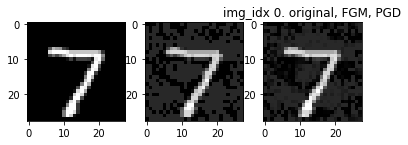

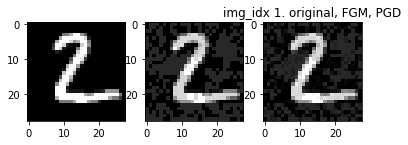

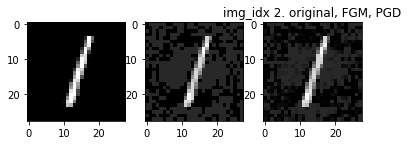

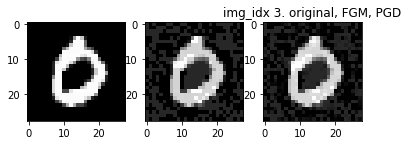

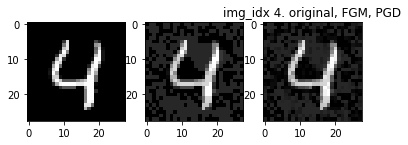

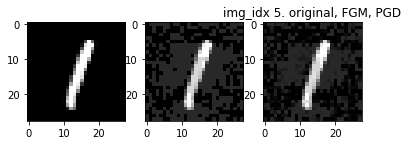

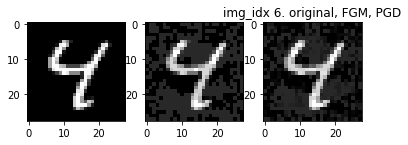

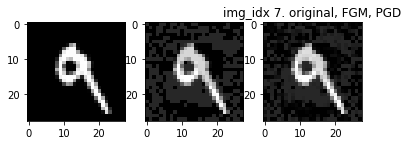

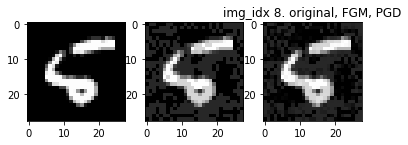

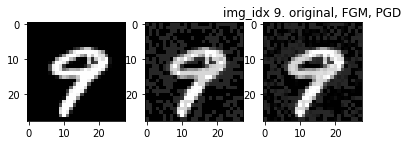

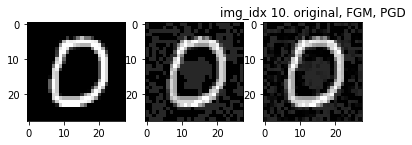

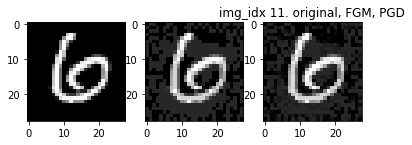

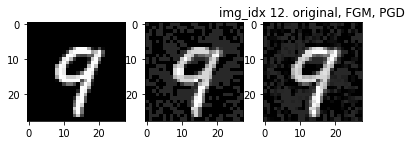

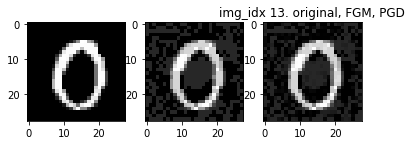

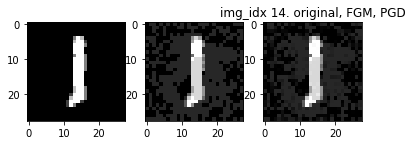

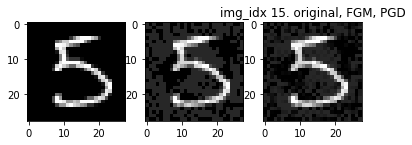

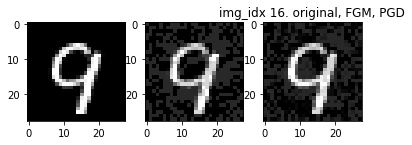

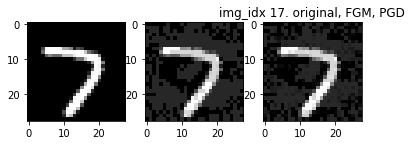

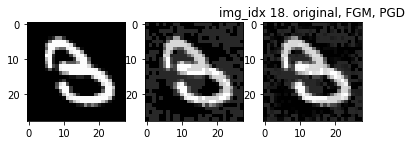

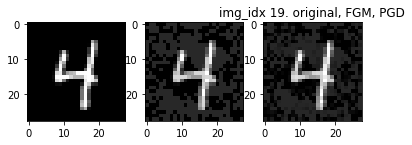

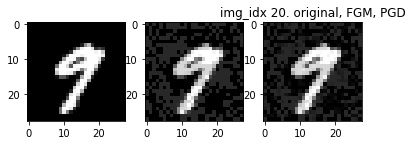

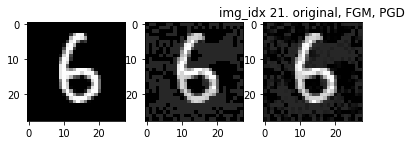

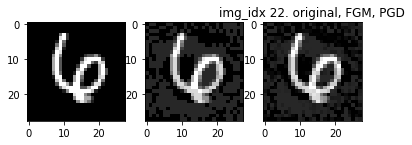

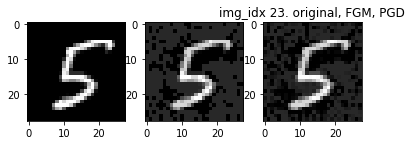

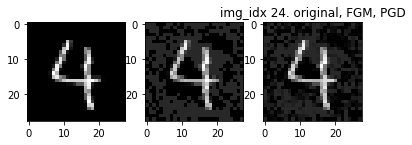

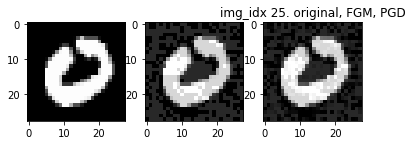

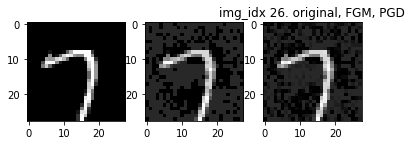

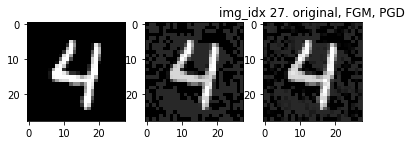

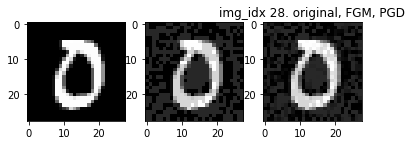

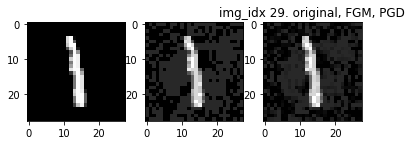

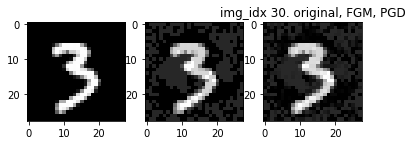

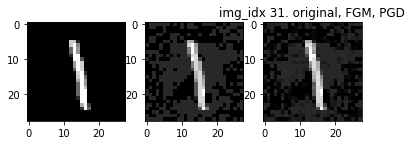

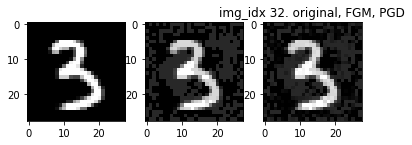

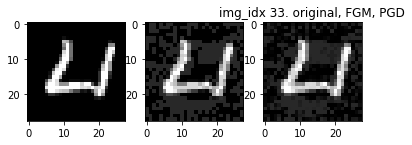

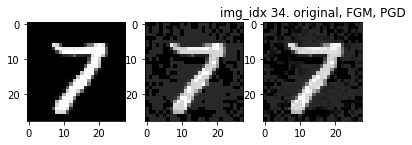

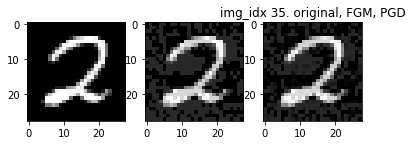

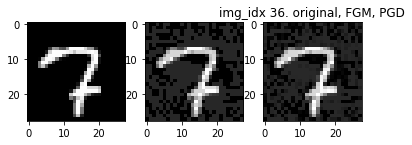

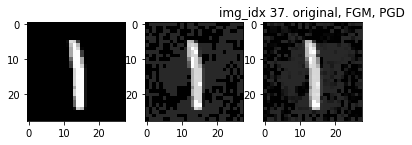

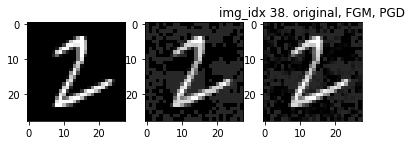

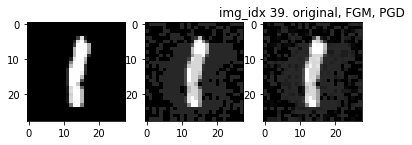

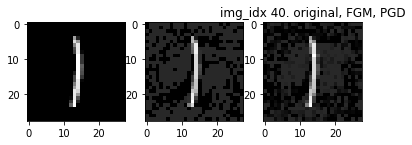

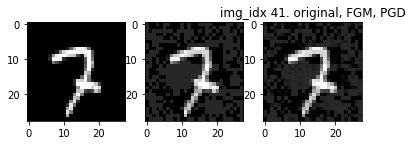

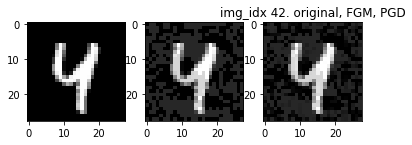

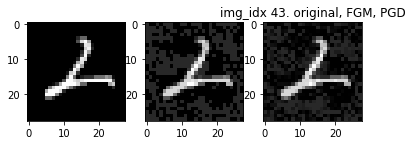

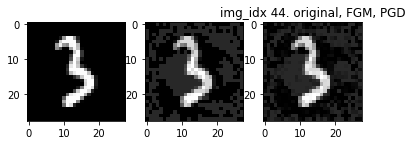

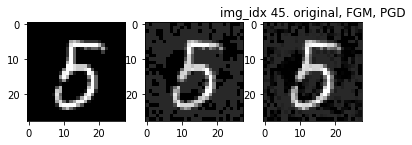

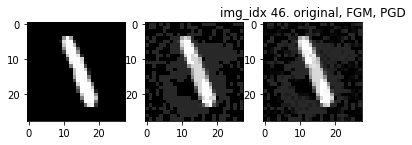

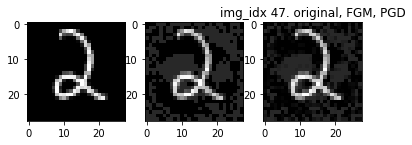

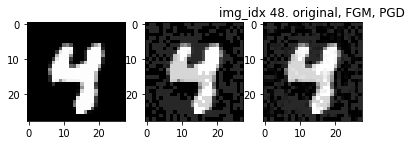

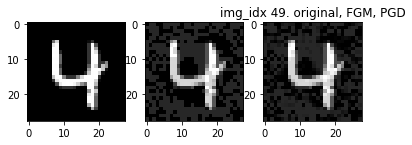

In [9]:
total = 50

org_ratio = 0
fgm_ratio = 0
pgd_ratio = 0

org_counterexample = []
fgm_counterexample = []
pgd_counterexample = []


for img_idx in range(0, total):
    (x, y) = torch.utils.data.Subset(dataset2, [img_idx])[0]
    
    ep = 0.0001
    
    stable_idx = all_alpha_patterns[ep][y]["stable_idx"]
    active_neurons_idx = all_alpha_patterns[ep][y]["active_neurons"]
    non_active_neurons_idx = all_alpha_patterns[ep][y]["non_active_neurons"]
    alpha_pattern = all_alpha_patterns[ep][y]["alpha_pattern"]
    
    x_extend = x[None, :]
    
    x_extend= x_extend.to(device)
    x_fgm = fast_gradient_method(model, x_extend, atk_eps, np.inf)
    x_pgd = projected_gradient_descent(model, x_extend, atk_eps, 0.01, 40, np.inf)
#     print(x_fgm)
    _, y_pred = model(x_extend).max(1)  # model prediction on clean examples
    _, y_pred_fgm = model(x_fgm).max(
        1
    )  # model prediction on FGM adversarial examples
    _, y_pred_pgd = model(x_pgd).max(
        1
    )  # model prediction on PGD adversarial examples
    
    print("img_idx: {}, Predictions --- label: {}, original: {}, fgm: {}, pgd: {}".format(img_idx, y, y_pred.item(), y_pred_fgm.item(), y_pred_pgd.item()))
    
    
    org_pattern = model.get_pattern(x_extend, layers, device, flatten = True)
    fgm_pattern = model.get_pattern(x_fgm, layers, device, flatten = True)
    pgd_pattern = model.get_pattern(x_pgd, layers, device, flatten = True)
    
    
    org_fgm_checking = org_pattern == fgm_pattern
    org_pgd_checking = org_pattern == pgd_pattern
    
    alp_org_checking = alpha_pattern == org_pattern[:, stable_idx]
    alp_fgm_checking = alpha_pattern == fgm_pattern[:, stable_idx]
    alp_pgd_checking = alpha_pattern == pgd_pattern[:, stable_idx]
    
    print("same activation status ratio for org and fgm:", org_fgm_checking.sum()/len(org_fgm_checking[0]) )
    print("same activation status ratio for org and pgd:", org_pgd_checking.sum()/len(org_pgd_checking[0]) )
    
    print("\n")
    
    print("label: {}, org_pred: {}".format( y, y_pred.item()))
    print("same alpha pattern for org:", alp_org_checking.sum()== len(alp_org_checking[0]), "\n" )
    print("label: {}, fgm_pred: {}".format( y, y_pred_fgm.item()))
    print("same alpha pattern for fgm:", alp_fgm_checking.sum()== len(alp_fgm_checking[0]),"\n" )
    print("label: {}, pgd_pred: {}".format( y, y_pred_pgd.item()))
    print("same alpha pattern for pgd:", alp_pgd_checking.sum()== len(alp_pgd_checking[0]),"\n" )
    
    if (y==y_pred.item() and alp_org_checking.sum()== len(alp_org_checking[0])) or (y!=y_pred.item() and alp_org_checking.sum()!= len(alp_org_checking[0])):
        org_ratio += 1
    else:
        org_counterexample.append(img_idx)
        
    if (y==y_pred_fgm.item() and alp_fgm_checking.sum()== len(alp_fgm_checking[0])) or (y!=y_pred_fgm.item() and alp_fgm_checking.sum()!= len(alp_fgm_checking[0])):
        fgm_ratio += 1
    else:
        fgm_counterexample.append(img_idx)
        
    if (y==y_pred_pgd.item() and alp_pgd_checking.sum()== len(alp_pgd_checking[0])) or (y!=y_pred_pgd.item() and alp_pgd_checking.sum()!= len(alp_pgd_checking[0])):
        pgd_ratio += 1
    else:
        pgd_counterexample.append(img_idx)
        
    print("===========")
#     figure = plt.figure()
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(x.reshape(28, 28), cmap="gray")
    axarr[1].imshow(x_fgm[0].cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[2].imshow(x_pgd[0].cpu().detach().numpy().reshape(28, 28), cmap="gray")
#     plt.title("Final pred prob: {}".format(pred_prob))
    plt.title("img_idx {}. original, FGM, PGD".format(img_idx))
#     plt.close(f)

org_ratio = org_ratio / total
fgm_ratio = fgm_ratio / total
pgd_ratio = pgd_ratio / total

print("org pred check consistent with alpha pattern check ratio: {}\n org counter examples image idx: {}\n".format( org_ratio, org_counterexample))
print("fgm pred check consistent with alpha pattern check ratio: {}\n fgm counter examples image idx: {}\n".format( fgm_ratio, fgm_counterexample))
print("pgd pred check consistent with alpha pattern check ratio: {}\n pgd counter examples image idx: {}\n".format( pgd_ratio, pgd_counterexample))

img_idx: 0, Predictions --- label: 7, original: 7, ns: 7
same activation status ratio for org and ns: 0.9737991266375546


label: 7, org_pred: 7
same alpha pattern for org: True 

label: 7, ns_pred: 7
same alpha pattern for ns: True 

img_idx: 1, Predictions --- label: 2, original: 2, ns: 2
same activation status ratio for org and ns: 0.9868995633187773


label: 2, org_pred: 2
same alpha pattern for org: True 

label: 2, ns_pred: 2
same alpha pattern for ns: True 

img_idx: 2, Predictions --- label: 1, original: 1, ns: 1
same activation status ratio for org and ns: 0.9519650655021834


label: 1, org_pred: 1
same alpha pattern for org: True 

label: 1, ns_pred: 1
same alpha pattern for ns: True 

img_idx: 3, Predictions --- label: 0, original: 0, ns: 0
same activation status ratio for org and ns: 0.9934497816593887


label: 0, org_pred: 0
same alpha pattern for org: True 

label: 0, ns_pred: 0
same alpha pattern for ns: True 

img_idx: 4, Predictions --- label: 4, original: 4, ns: 4
sam

C:\Users\xxjtr\AppData\Local\Temp\ipykernel_2504\1290616289.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(1,2)


img_idx: 21, Predictions --- label: 6, original: 6, ns: 6
same activation status ratio for org and ns: 0.9781659388646288


label: 6, org_pred: 6
same alpha pattern for org: True 

label: 6, ns_pred: 6
same alpha pattern for ns: True 

img_idx: 22, Predictions --- label: 6, original: 6, ns: 6
same activation status ratio for org and ns: 0.9847161572052402


label: 6, org_pred: 6
same alpha pattern for org: True 

label: 6, ns_pred: 6
same alpha pattern for ns: True 

img_idx: 23, Predictions --- label: 5, original: 5, ns: 5
same activation status ratio for org and ns: 0.9847161572052402


label: 5, org_pred: 5
same alpha pattern for org: True 

label: 5, ns_pred: 5
same alpha pattern for ns: True 

img_idx: 24, Predictions --- label: 4, original: 4, ns: 4
same activation status ratio for org and ns: 0.9606986899563319


label: 4, org_pred: 4
same alpha pattern for org: True 

label: 4, ns_pred: 4
same alpha pattern for ns: True 

img_idx: 25, Predictions --- label: 0, original: 0, ns: 

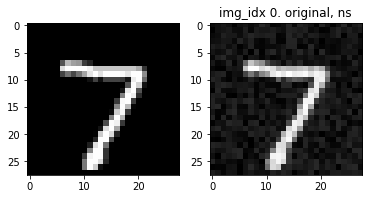

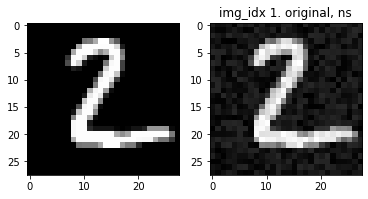

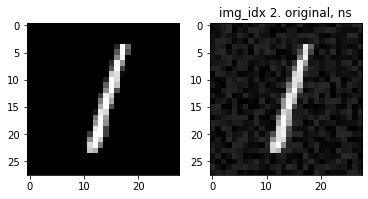

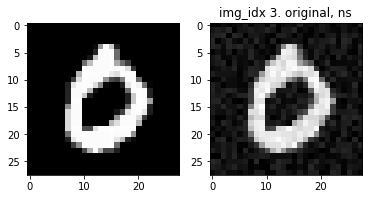

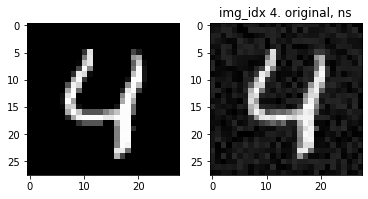

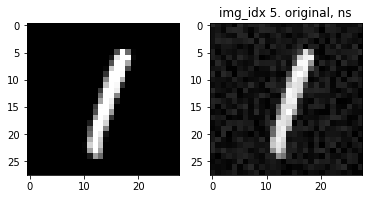

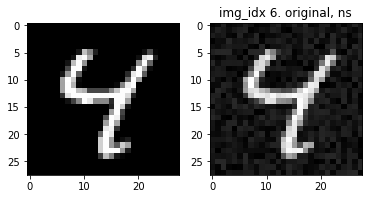

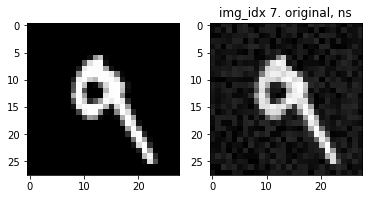

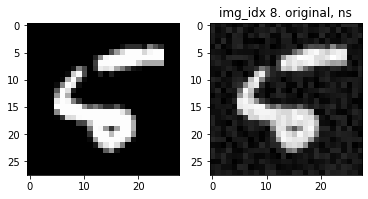

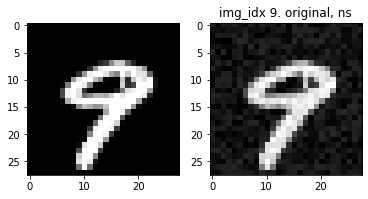

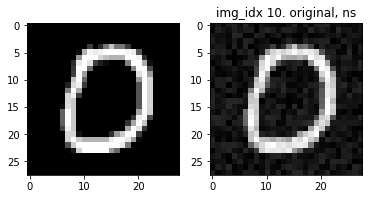

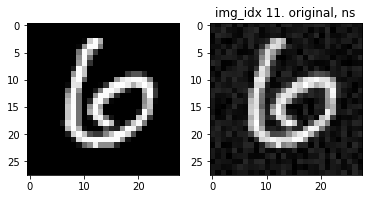

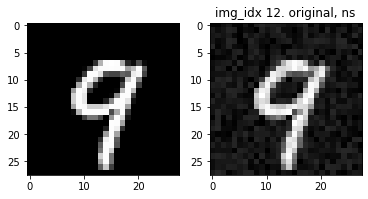

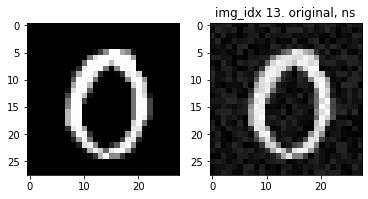

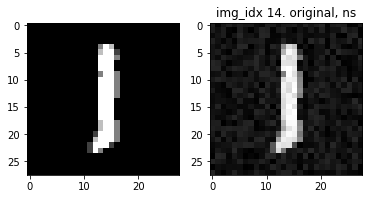

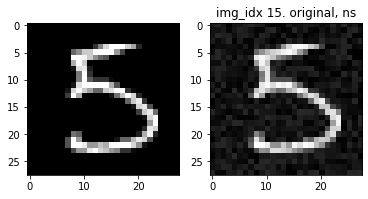

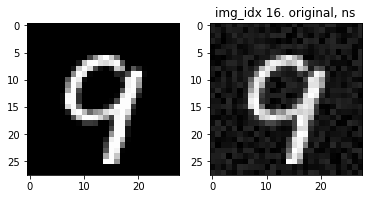

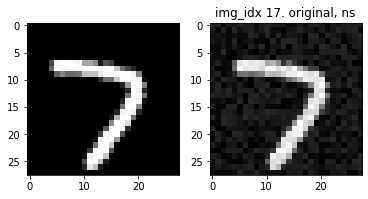

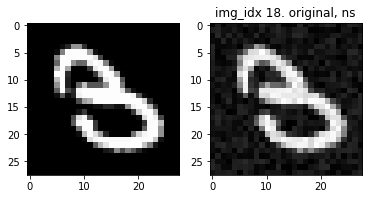

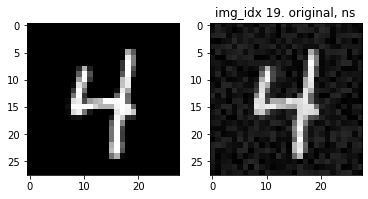

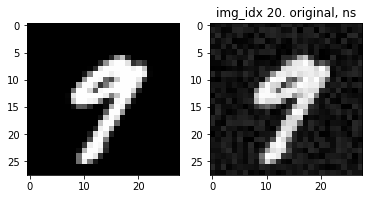

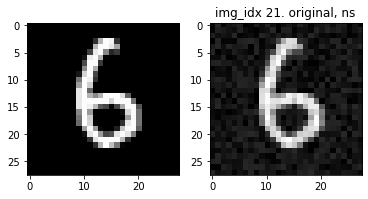

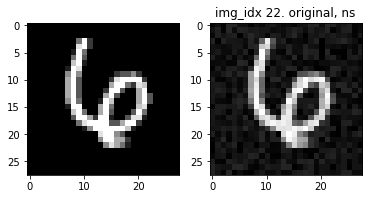

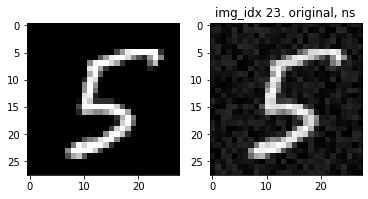

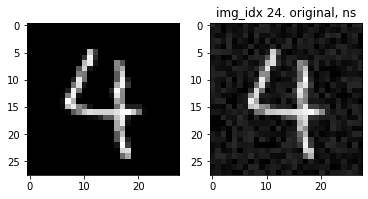

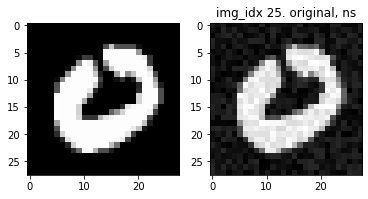

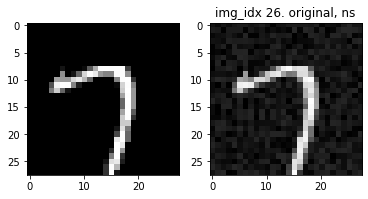

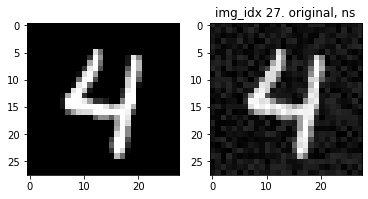

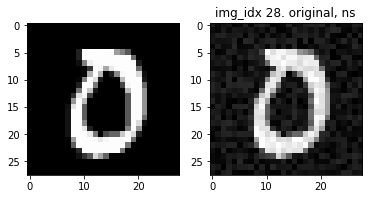

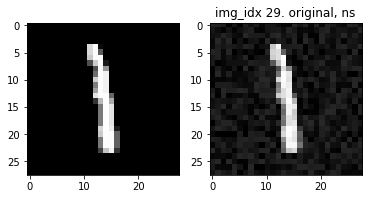

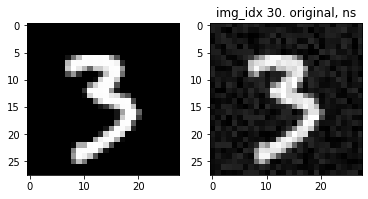

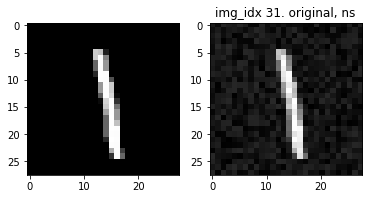

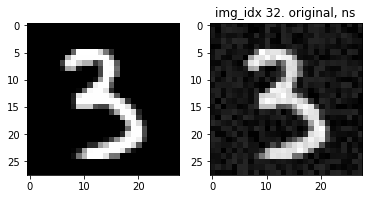

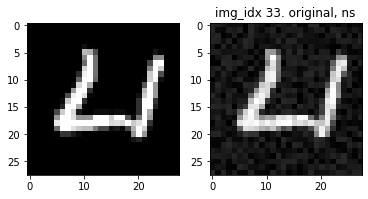

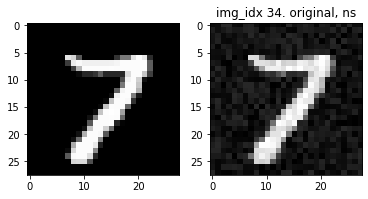

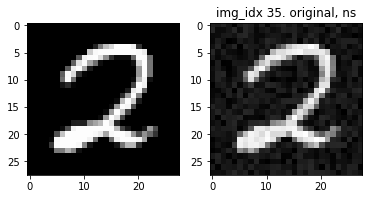

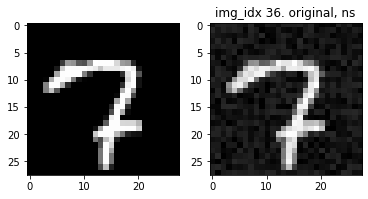

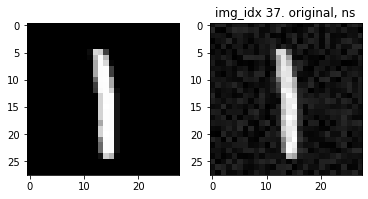

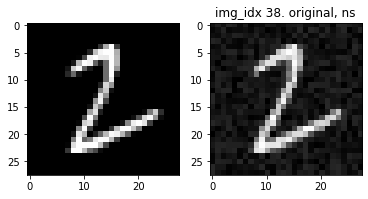

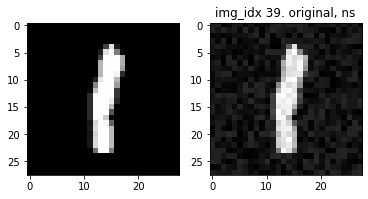

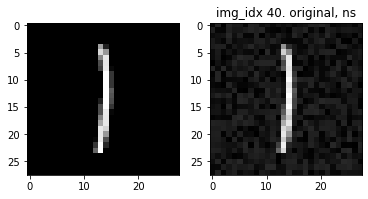

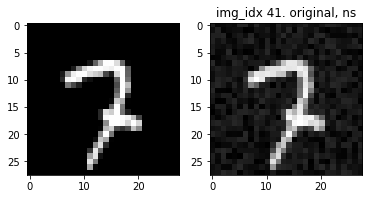

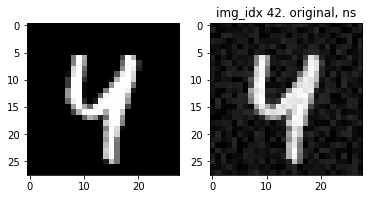

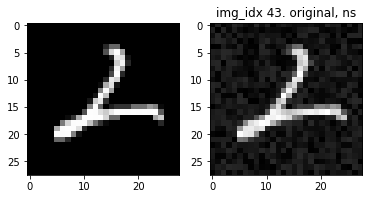

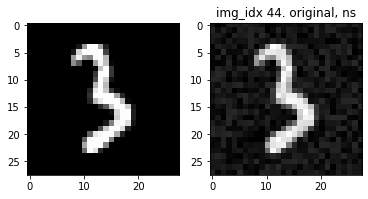

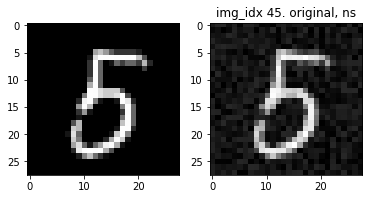

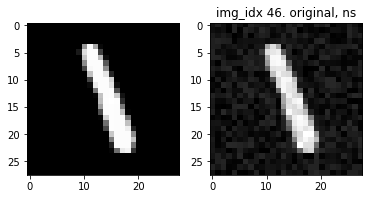

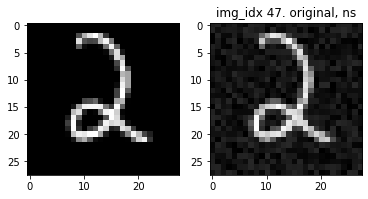

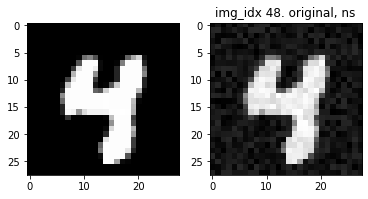

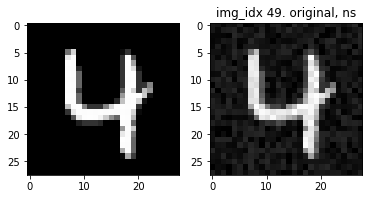

In [12]:
total = 50

org_ratio = 0
ns_ratio = 0


org_counterexample = []
ns_counterexample = []



for img_idx in range(0, total):
    (x, y) = torch.utils.data.Subset(dataset2, [img_idx])[0]
    
    ep = 0.0001
    
    stable_idx = all_alpha_patterns[ep][y]["stable_idx"]
    active_neurons_idx = all_alpha_patterns[ep][y]["active_neurons"]
    non_active_neurons_idx = all_alpha_patterns[ep][y]["non_active_neurons"]
    alpha_pattern = all_alpha_patterns[ep][y]["alpha_pattern"]
    
    x_extend = x[None, :]
    
    x_extend= x_extend.to(device)
    x_ns = noise(x_extend, atk_eps, np.inf)
   
    _, y_pred = model(x_extend).max(1)  # model prediction on clean examples
    _, y_pred_ns= model(x_ns).max(
        1
    )  # model prediction on FGM adversarial examples
   
    print("img_idx: {}, Predictions --- label: {}, original: {}, ns: {}".format(img_idx, y, y_pred.item(), y_pred_ns.item()))
    
    
    org_pattern = model.get_pattern(x_extend, layers, device, flatten = True)
    ns_pattern = model.get_pattern(x_ns, layers, device, flatten = True)
    
    
    org_ns_checking = org_pattern == ns_pattern
    
    alp_org_checking = alpha_pattern == org_pattern[:, stable_idx]
    alp_ns_checking = alpha_pattern == ns_pattern[:, stable_idx]
    
    print("same activation status ratio for org and ns:", org_ns_checking.sum()/len(org_ns_checking[0]) )
    
    print("\n")
    
    print("label: {}, org_pred: {}".format( y, y_pred.item()))
    print("same alpha pattern for org:", alp_org_checking.sum()== len(alp_org_checking[0]), "\n" )
    print("label: {}, ns_pred: {}".format( y, y_pred_ns.item()))
    print("same alpha pattern for ns:", alp_ns_checking.sum()== len(alp_ns_checking[0]),"\n" )

    
    if (y==y_pred.item() and alp_org_checking.sum()== len(alp_org_checking[0])) or (y!=y_pred.item() and alp_org_checking.sum()!= len(alp_org_checking[0])):
        org_ratio += 1
    else:
        org_counterexample.append(img_idx)
        
    if (y==y_pred_ns.item() and alp_ns_checking.sum()== len(alp_ns_checking[0])) or (y!=y_pred_ns.item() and alp_ns_checking.sum()!= len(alp_ns_checking[0])):
        ns_ratio += 1
    else:
        ns_counterexample.append(img_idx)
        
   
        
    print("===========")
#     figure = plt.figure()
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(x.reshape(28, 28), cmap="gray")
    axarr[1].imshow(x_ns[0].cpu().detach().numpy().reshape(28, 28), cmap="gray")
#     plt.title("Final pred prob: {}".format(pred_prob))
    plt.title("img_idx {}. original, ns".format(img_idx))
#     plt.close(f)

org_ratio = org_ratio / total
ns_ratio = ns_ratio / total

print("org pred check consistent with alpha pattern check ratio: {}\n org counter examples image idx: {}\n".format( org_ratio, org_counterexample))
print("ns pred check consistent with alpha pattern check ratio: {}\n ns counter examples image idx: {}\n".format( ns_ratio, ns_counterexample))


iteration: 1, 2 distance 1.5778E+01
iteration: 2, 2 distance 1.4086E+01
iteration: 3, 2 distance 1.3008E+01
iteration: 4, 2 distance 1.3303E+01
iteration: 5, 2 distance 1.2951E+01
iteration: 6, 2 distance 1.2549E+01
iteration: 7, 2 distance 1.2804E+01
iteration: 8, 2 distance 1.2948E+01
iteration: 9, 2 distance 1.2845E+01
iteration: 10, 2 distance 1.3057E+01
iteration: 11, 2 distance 1.2954E+01
iteration: 12, 2 distance 1.2968E+01
iteration: 13, 2 distance 1.2950E+01
iteration: 14, 2 distance 1.3034E+01
iteration: 15, 2 distance 1.3000E+01
iteration: 16, 2 distance 1.3073E+01
iteration: 17, 2 distance 1.3141E+01
iteration: 18, 2 distance 1.3341E+01
iteration: 19, 2 distance 1.3214E+01
iteration: 20, 2 distance 1.3284E+01
iteration: 21, 2 distance 1.3396E+01
iteration: 22, 2 distance 1.3328E+01
iteration: 23, 2 distance 1.3396E+01
iteration: 24, 2 distance 1.3380E+01
iteration: 25, 2 distance 1.3312E+01
iteration: 26, 2 distance 1.3475E+01
iteration: 27, 2 distance 1.3515E+01
iteration:

iteration: 17, 2 distance 1.7544E+01
iteration: 18, 2 distance 1.7439E+01
iteration: 19, 2 distance 1.7461E+01
iteration: 20, 2 distance 1.7472E+01
iteration: 21, 2 distance 1.7603E+01
iteration: 22, 2 distance 1.7308E+01
iteration: 23, 2 distance 1.7515E+01
iteration: 24, 2 distance 1.7464E+01
iteration: 25, 2 distance 1.7597E+01
iteration: 26, 2 distance 1.7709E+01
iteration: 27, 2 distance 1.7701E+01
iteration: 28, 2 distance 1.7493E+01
iteration: 29, 2 distance 1.7780E+01
iteration: 30, 2 distance 1.7937E+01
iteration: 31, 2 distance 1.7839E+01
iteration: 32, 2 distance 1.7961E+01
iteration: 33, 2 distance 1.7930E+01
iteration: 34, 2 distance 1.8009E+01
iteration: 35, 2 distance 1.7830E+01
iteration: 36, 2 distance 1.7765E+01
iteration: 37, 2 distance 1.8000E+01
iteration: 38, 2 distance 1.8054E+01
iteration: 39, 2 distance 1.7953E+01
iteration: 40, 2 distance 1.8094E+01
iteration: 41, 2 distance 1.8214E+01
iteration: 42, 2 distance 1.8063E+01
iteration: 43, 2 distance 1.8043E+01
i

iteration: 29, 2 distance 1.0765E+01
iteration: 30, 2 distance 1.0763E+01
iteration: 31, 2 distance 1.0696E+01
iteration: 32, 2 distance 1.0805E+01
iteration: 33, 2 distance 1.0937E+01
iteration: 34, 2 distance 1.0830E+01
iteration: 35, 2 distance 1.0922E+01
iteration: 36, 2 distance 1.0932E+01
iteration: 37, 2 distance 1.0974E+01
iteration: 38, 2 distance 1.0997E+01
iteration: 39, 2 distance 1.1167E+01
iteration: 40, 2 distance 1.1089E+01
iteration: 41, 2 distance 1.1234E+01
iteration: 42, 2 distance 1.1142E+01
iteration: 43, 2 distance 1.1054E+01
iteration: 44, 2 distance 1.1100E+01
iteration: 45, 2 distance 1.1117E+01
iteration: 46, 2 distance 1.1198E+01
iteration: 47, 2 distance 1.1389E+01
iteration: 48, 2 distance 1.1359E+01
iteration: 49, 2 distance 1.1342E+01
iteration: 50, 2 distance 1.1219E+01
iteration: 51, 2 distance 1.1400E+01
iteration: 52, 2 distance 1.1579E+01
iteration: 53, 2 distance 1.1264E+01
iteration: 54, 2 distance 1.1272E+01
iteration: 55, 2 distance 1.1601E+01
i

iteration: 39, 2 distance 1.5763E+01
iteration: 40, 2 distance 1.5859E+01
iteration: 41, 2 distance 1.5491E+01
iteration: 42, 2 distance 1.5889E+01
iteration: 43, 2 distance 1.5933E+01
iteration: 44, 2 distance 1.5772E+01
iteration: 45, 2 distance 1.5861E+01
iteration: 46, 2 distance 1.5800E+01
iteration: 47, 2 distance 1.5898E+01
iteration: 48, 2 distance 1.6065E+01
iteration: 49, 2 distance 1.5857E+01
iteration: 50, 2 distance 1.5637E+01
iteration: 51, 2 distance 1.5852E+01
iteration: 52, 2 distance 1.5853E+01
iteration: 53, 2 distance 1.6003E+01
iteration: 54, 2 distance 1.6150E+01
iteration: 55, 2 distance 1.6032E+01
iteration: 56, 2 distance 1.5972E+01
iteration: 57, 2 distance 1.5941E+01
iteration: 58, 2 distance 1.5982E+01
iteration: 59, 2 distance 1.5957E+01
iteration: 60, 2 distance 1.6058E+01
iteration: 61, 2 distance 1.6175E+01
iteration: 62, 2 distance 1.6250E+01
iteration: 63, 2 distance 1.6130E+01
iteration: 64, 2 distance 1.6034E+01
img_idx: 9, Predictions --- label: 9, 

iteration: 50, 2 distance 1.3881E+01
iteration: 51, 2 distance 1.3689E+01
iteration: 52, 2 distance 1.3733E+01
iteration: 53, 2 distance 1.3894E+01
iteration: 54, 2 distance 1.3970E+01
iteration: 55, 2 distance 1.3974E+01
iteration: 56, 2 distance 1.3873E+01
iteration: 57, 2 distance 1.3886E+01
iteration: 58, 2 distance 1.3982E+01
iteration: 59, 2 distance 1.3941E+01
iteration: 60, 2 distance 1.3974E+01
iteration: 61, 2 distance 1.3961E+01
iteration: 62, 2 distance 1.4047E+01
iteration: 63, 2 distance 1.4153E+01
iteration: 64, 2 distance 1.4062E+01
img_idx: 12, Predictions --- label: 9, original: 9, hsja: 9
same activation status ratio for org and hsja: 0.9650655021834061


label: 9, org_pred: 9
same alpha pattern for org: True 

label: 9, hsja_pred: 9
same alpha pattern for hsja: True 

iteration: 1, 2 distance 1.8991E+01
iteration: 2, 2 distance 1.3634E+01
iteration: 3, 2 distance 1.2581E+01
iteration: 4, 2 distance 1.2544E+01
iteration: 5, 2 distance 1.2265E+01
iteration: 6, 2 dista

iteration: 60, 2 distance 6.1022E+00
iteration: 61, 2 distance 6.0481E+00
iteration: 62, 2 distance 6.1622E+00
iteration: 63, 2 distance 5.9575E+00
iteration: 64, 2 distance 6.1790E+00
img_idx: 15, Predictions --- label: 5, original: 5, hsja: 5
same activation status ratio for org and hsja: 0.980349344978166


label: 5, org_pred: 5
same alpha pattern for org: True 

label: 5, hsja_pred: 5
same alpha pattern for hsja: True 

iteration: 1, 2 distance 1.3908E+01
iteration: 2, 2 distance 1.2845E+01
iteration: 3, 2 distance 1.1999E+01
iteration: 4, 2 distance 1.1859E+01
iteration: 5, 2 distance 1.2221E+01
iteration: 6, 2 distance 1.2408E+01
iteration: 7, 2 distance 1.2200E+01
iteration: 8, 2 distance 1.2405E+01
iteration: 9, 2 distance 1.2179E+01
iteration: 10, 2 distance 1.2687E+01
iteration: 11, 2 distance 1.2500E+01
iteration: 12, 2 distance 1.2185E+01
iteration: 13, 2 distance 1.2522E+01
iteration: 14, 2 distance 1.2425E+01
iteration: 15, 2 distance 1.2449E+01
iteration: 16, 2 distance 

iteration: 6, 2 distance 9.9868E+00
iteration: 7, 2 distance 1.0128E+01
iteration: 8, 2 distance 1.0104E+01
iteration: 9, 2 distance 1.0042E+01
iteration: 10, 2 distance 1.0186E+01
iteration: 11, 2 distance 1.0351E+01
iteration: 12, 2 distance 1.0236E+01
iteration: 13, 2 distance 1.0367E+01
iteration: 14, 2 distance 1.0550E+01
iteration: 15, 2 distance 1.0424E+01
iteration: 16, 2 distance 1.0400E+01
iteration: 17, 2 distance 1.0396E+01
iteration: 18, 2 distance 1.0514E+01
iteration: 19, 2 distance 1.0590E+01
iteration: 20, 2 distance 1.0589E+01
iteration: 21, 2 distance 1.0484E+01
iteration: 22, 2 distance 1.0604E+01
iteration: 23, 2 distance 1.0529E+01
iteration: 24, 2 distance 1.0597E+01
iteration: 25, 2 distance 1.0772E+01
iteration: 26, 2 distance 1.0691E+01
iteration: 27, 2 distance 1.0745E+01
iteration: 28, 2 distance 1.0940E+01
iteration: 29, 2 distance 1.0835E+01
iteration: 30, 2 distance 1.0834E+01
iteration: 31, 2 distance 1.0868E+01
iteration: 32, 2 distance 1.0934E+01
itera

C:\Users\xxjtr\AppData\Local\Temp\ipykernel_2504\3229033242.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(1,2)


iteration: 6, 2 distance 1.2140E+01
iteration: 7, 2 distance 1.2260E+01
iteration: 8, 2 distance 1.2269E+01
iteration: 9, 2 distance 1.2460E+01
iteration: 10, 2 distance 1.2761E+01
iteration: 11, 2 distance 1.2352E+01
iteration: 12, 2 distance 1.2618E+01
iteration: 13, 2 distance 1.2682E+01
iteration: 14, 2 distance 1.2845E+01
iteration: 15, 2 distance 1.2628E+01
iteration: 16, 2 distance 1.2810E+01
iteration: 17, 2 distance 1.2934E+01
iteration: 18, 2 distance 1.2877E+01
iteration: 19, 2 distance 1.3128E+01
iteration: 20, 2 distance 1.2848E+01
iteration: 21, 2 distance 1.2946E+01
iteration: 22, 2 distance 1.2943E+01
iteration: 23, 2 distance 1.2970E+01
iteration: 24, 2 distance 1.2916E+01
iteration: 25, 2 distance 1.3225E+01
iteration: 26, 2 distance 1.3071E+01
iteration: 27, 2 distance 1.3031E+01
iteration: 28, 2 distance 1.3260E+01
iteration: 29, 2 distance 1.3488E+01
iteration: 30, 2 distance 1.3312E+01
iteration: 31, 2 distance 1.3301E+01
iteration: 32, 2 distance 1.3266E+01
itera

iteration: 16, 2 distance 4.7354E+00
iteration: 17, 2 distance 4.9096E+00
iteration: 18, 2 distance 4.9351E+00
iteration: 19, 2 distance 4.8122E+00
iteration: 20, 2 distance 5.1820E+00
iteration: 21, 2 distance 4.9187E+00
iteration: 22, 2 distance 5.2249E+00
iteration: 23, 2 distance 5.1217E+00
iteration: 24, 2 distance 5.0139E+00
iteration: 25, 2 distance 5.3667E+00
iteration: 26, 2 distance 5.0086E+00
iteration: 27, 2 distance 5.4921E+00
iteration: 28, 2 distance 5.1209E+00
iteration: 29, 2 distance 5.4977E+00
iteration: 30, 2 distance 5.3408E+00
iteration: 31, 2 distance 5.3657E+00
iteration: 32, 2 distance 5.5806E+00
iteration: 33, 2 distance 5.3206E+00
iteration: 34, 2 distance 5.3677E+00
iteration: 35, 2 distance 5.6534E+00
iteration: 36, 2 distance 5.5419E+00
iteration: 37, 2 distance 5.4741E+00
iteration: 38, 2 distance 5.3636E+00
iteration: 39, 2 distance 5.6311E+00
iteration: 40, 2 distance 5.5214E+00
iteration: 41, 2 distance 5.7463E+00
iteration: 42, 2 distance 5.6219E+00
i

iteration: 27, 2 distance 1.1019E+01
iteration: 28, 2 distance 1.1054E+01
iteration: 29, 2 distance 1.1200E+01
iteration: 30, 2 distance 1.1244E+01
iteration: 31, 2 distance 1.1167E+01
iteration: 32, 2 distance 1.1095E+01
iteration: 33, 2 distance 1.1260E+01
iteration: 34, 2 distance 1.1338E+01
iteration: 35, 2 distance 1.1253E+01
iteration: 36, 2 distance 1.1293E+01
iteration: 37, 2 distance 1.1207E+01
iteration: 38, 2 distance 1.1229E+01
iteration: 39, 2 distance 1.1246E+01
iteration: 40, 2 distance 1.1241E+01
iteration: 41, 2 distance 1.1151E+01
iteration: 42, 2 distance 1.1315E+01
iteration: 43, 2 distance 1.1271E+01
iteration: 44, 2 distance 1.1318E+01
iteration: 45, 2 distance 1.1378E+01
iteration: 46, 2 distance 1.1257E+01
iteration: 47, 2 distance 1.1300E+01
iteration: 48, 2 distance 1.1396E+01
iteration: 49, 2 distance 1.1507E+01
iteration: 50, 2 distance 1.1341E+01
iteration: 51, 2 distance 1.1431E+01
iteration: 52, 2 distance 1.1418E+01
iteration: 53, 2 distance 1.1432E+01
i

iteration: 37, 2 distance 1.5497E+01
iteration: 38, 2 distance 1.5529E+01
iteration: 39, 2 distance 1.5449E+01
iteration: 40, 2 distance 1.5624E+01
iteration: 41, 2 distance 1.5590E+01
iteration: 42, 2 distance 1.5589E+01
iteration: 43, 2 distance 1.5656E+01
iteration: 44, 2 distance 1.5749E+01
iteration: 45, 2 distance 1.5605E+01
iteration: 46, 2 distance 1.5815E+01
iteration: 47, 2 distance 1.5783E+01
iteration: 48, 2 distance 1.5657E+01
iteration: 49, 2 distance 1.5714E+01
iteration: 50, 2 distance 1.5933E+01
iteration: 51, 2 distance 1.5659E+01
iteration: 52, 2 distance 1.5876E+01
iteration: 53, 2 distance 1.5861E+01
iteration: 54, 2 distance 1.5753E+01
iteration: 55, 2 distance 1.5714E+01
iteration: 56, 2 distance 1.5825E+01
iteration: 57, 2 distance 1.5875E+01
iteration: 58, 2 distance 1.5908E+01
iteration: 59, 2 distance 1.5871E+01
iteration: 60, 2 distance 1.5898E+01
iteration: 61, 2 distance 1.5819E+01
iteration: 62, 2 distance 1.5919E+01
iteration: 63, 2 distance 1.5920E+01
i

iteration: 48, 2 distance 9.5583E+00
iteration: 49, 2 distance 1.0017E+01
iteration: 50, 2 distance 9.8197E+00
iteration: 51, 2 distance 9.9007E+00
iteration: 52, 2 distance 9.9714E+00
iteration: 53, 2 distance 9.9282E+00
iteration: 54, 2 distance 9.9508E+00
iteration: 55, 2 distance 1.0174E+01
iteration: 56, 2 distance 1.0326E+01
iteration: 57, 2 distance 1.0017E+01
iteration: 58, 2 distance 1.0178E+01
iteration: 59, 2 distance 1.0018E+01
iteration: 60, 2 distance 1.0082E+01
iteration: 61, 2 distance 1.0123E+01
iteration: 62, 2 distance 1.0122E+01
iteration: 63, 2 distance 1.0176E+01
iteration: 64, 2 distance 1.0200E+01
img_idx: 33, Predictions --- label: 4, original: 6, hsja: 6
same activation status ratio for org and hsja: 0.9585152838427947


label: 4, org_pred: 6
same alpha pattern for org: False 

label: 4, hsja_pred: 6
same alpha pattern for hsja: False 

iteration: 1, 2 distance 1.0618E+01
iteration: 2, 2 distance 1.0200E+01
iteration: 3, 2 distance 9.8846E+00
iteration: 4, 2 d

iteration: 58, 2 distance 1.3952E+01
iteration: 59, 2 distance 1.4089E+01
iteration: 60, 2 distance 1.4088E+01
iteration: 61, 2 distance 1.4111E+01
iteration: 62, 2 distance 1.4197E+01
iteration: 63, 2 distance 1.4073E+01
iteration: 64, 2 distance 1.4167E+01
img_idx: 36, Predictions --- label: 7, original: 7, hsja: 7
same activation status ratio for org and hsja: 0.9192139737991266


label: 7, org_pred: 7
same alpha pattern for org: True 

label: 7, hsja_pred: 7
same alpha pattern for hsja: True 

iteration: 1, 2 distance 1.1498E+01
iteration: 2, 2 distance 1.0455E+01
iteration: 3, 2 distance 1.0658E+01
iteration: 4, 2 distance 1.0632E+01
iteration: 5, 2 distance 1.0680E+01
iteration: 6, 2 distance 1.0889E+01
iteration: 7, 2 distance 1.1021E+01
iteration: 8, 2 distance 1.0611E+01
iteration: 9, 2 distance 1.0879E+01
iteration: 10, 2 distance 1.0865E+01
iteration: 11, 2 distance 1.0882E+01
iteration: 12, 2 distance 1.1090E+01
iteration: 13, 2 distance 1.1204E+01
iteration: 14, 2 distance

iteration: 1, 2 distance 1.0005E+01
iteration: 2, 2 distance 9.0653E+00
iteration: 3, 2 distance 8.6737E+00
iteration: 4, 2 distance 9.3168E+00
iteration: 5, 2 distance 8.9187E+00
iteration: 6, 2 distance 9.1556E+00
iteration: 7, 2 distance 9.0472E+00
iteration: 8, 2 distance 9.2517E+00
iteration: 9, 2 distance 9.4449E+00
iteration: 10, 2 distance 9.5458E+00
iteration: 11, 2 distance 9.7656E+00
iteration: 12, 2 distance 9.7573E+00
iteration: 13, 2 distance 9.5508E+00
iteration: 14, 2 distance 9.4960E+00
iteration: 15, 2 distance 9.6571E+00
iteration: 16, 2 distance 9.6513E+00
iteration: 17, 2 distance 1.0004E+01
iteration: 18, 2 distance 9.8439E+00
iteration: 19, 2 distance 1.0063E+01
iteration: 20, 2 distance 1.0052E+01
iteration: 21, 2 distance 1.0039E+01
iteration: 22, 2 distance 9.7014E+00
iteration: 23, 2 distance 1.0086E+01
iteration: 24, 2 distance 1.0009E+01
iteration: 25, 2 distance 1.0006E+01
iteration: 26, 2 distance 1.0078E+01
iteration: 27, 2 distance 1.0209E+01
iteration:

iteration: 12, 2 distance 1.0458E+01
iteration: 13, 2 distance 9.9386E+00
iteration: 14, 2 distance 9.9759E+00
iteration: 15, 2 distance 1.0182E+01
iteration: 16, 2 distance 1.0114E+01
iteration: 17, 2 distance 9.9729E+00
iteration: 18, 2 distance 1.0337E+01
iteration: 19, 2 distance 1.0262E+01
iteration: 20, 2 distance 1.0530E+01
iteration: 21, 2 distance 1.0313E+01
iteration: 22, 2 distance 1.0157E+01
iteration: 23, 2 distance 1.0410E+01
iteration: 24, 2 distance 1.0557E+01
iteration: 25, 2 distance 1.0447E+01
iteration: 26, 2 distance 1.0542E+01
iteration: 27, 2 distance 1.0656E+01
iteration: 28, 2 distance 1.0715E+01
iteration: 29, 2 distance 1.0506E+01
iteration: 30, 2 distance 1.0681E+01
iteration: 31, 2 distance 1.0863E+01
iteration: 32, 2 distance 1.0834E+01
iteration: 33, 2 distance 1.1032E+01
iteration: 34, 2 distance 1.0886E+01
iteration: 35, 2 distance 1.0861E+01
iteration: 36, 2 distance 1.0959E+01
iteration: 37, 2 distance 1.0896E+01
iteration: 38, 2 distance 1.1099E+01
i

iteration: 22, 2 distance 5.4121E-04
iteration: 23, 2 distance 5.4121E-04
iteration: 24, 2 distance 5.4121E-04
iteration: 25, 2 distance 5.4121E-04
iteration: 26, 2 distance 5.4121E-04
iteration: 27, 2 distance 5.4121E-04
iteration: 28, 2 distance 5.4121E-04
iteration: 29, 2 distance 5.4121E-04
iteration: 30, 2 distance 5.4121E-04
iteration: 31, 2 distance 5.4121E-04
iteration: 32, 2 distance 5.4121E-04
iteration: 33, 2 distance 5.4121E-04
iteration: 34, 2 distance 5.4121E-04
iteration: 35, 2 distance 5.4121E-04
iteration: 36, 2 distance 5.4121E-04
iteration: 37, 2 distance 5.4121E-04
iteration: 38, 2 distance 5.4121E-04
iteration: 39, 2 distance 5.4121E-04
iteration: 40, 2 distance 5.4121E-04
iteration: 41, 2 distance 5.4121E-04
iteration: 42, 2 distance 5.4121E-04
iteration: 43, 2 distance 5.4121E-04
iteration: 44, 2 distance 5.4121E-04
iteration: 45, 2 distance 5.4121E-04
iteration: 46, 2 distance 5.4121E-04
iteration: 47, 2 distance 5.4121E-04
iteration: 48, 2 distance 5.4121E-04
i

iteration: 33, 2 distance 1.3473E+01
iteration: 34, 2 distance 1.3367E+01
iteration: 35, 2 distance 1.3422E+01
iteration: 36, 2 distance 1.3297E+01
iteration: 37, 2 distance 1.3621E+01
iteration: 38, 2 distance 1.3396E+01
iteration: 39, 2 distance 1.3557E+01
iteration: 40, 2 distance 1.3643E+01
iteration: 41, 2 distance 1.3448E+01
iteration: 42, 2 distance 1.3784E+01
iteration: 43, 2 distance 1.3603E+01
iteration: 44, 2 distance 1.3728E+01
iteration: 45, 2 distance 1.3778E+01
iteration: 46, 2 distance 1.3717E+01
iteration: 47, 2 distance 1.3833E+01
iteration: 48, 2 distance 1.3734E+01
iteration: 49, 2 distance 1.3789E+01
iteration: 50, 2 distance 1.3896E+01
iteration: 51, 2 distance 1.4024E+01
iteration: 52, 2 distance 1.3751E+01
iteration: 53, 2 distance 1.3982E+01
iteration: 54, 2 distance 1.4016E+01
iteration: 55, 2 distance 1.4028E+01
iteration: 56, 2 distance 1.3859E+01
iteration: 57, 2 distance 1.4018E+01
iteration: 58, 2 distance 1.3904E+01
iteration: 59, 2 distance 1.4290E+01
i

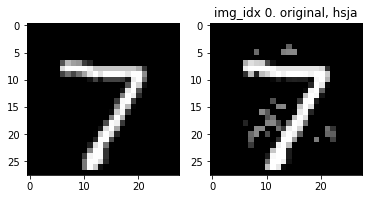

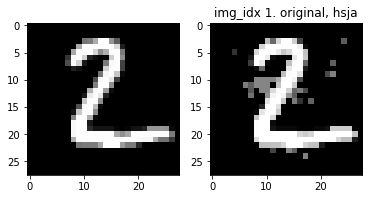

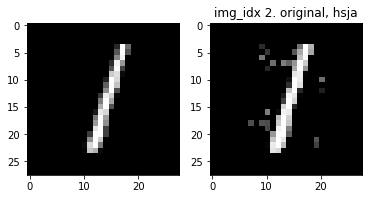

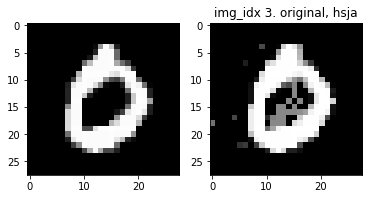

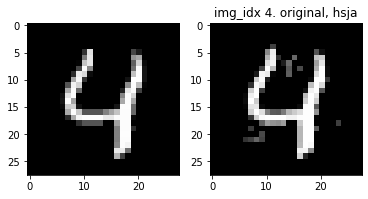

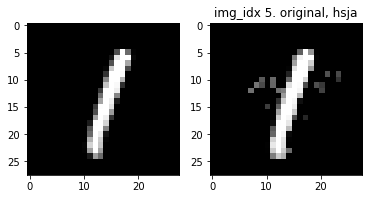

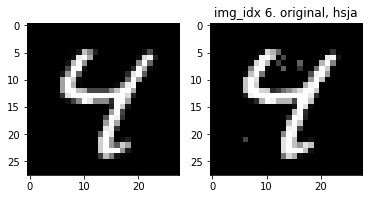

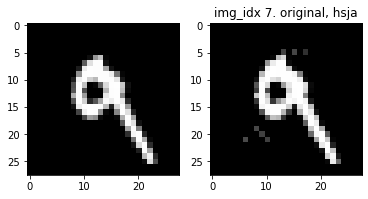

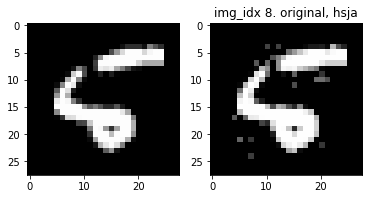

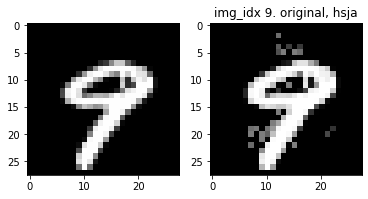

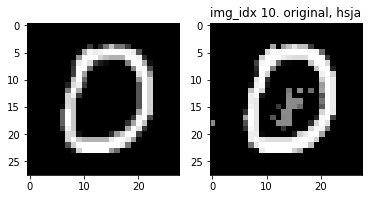

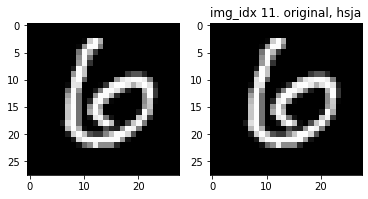

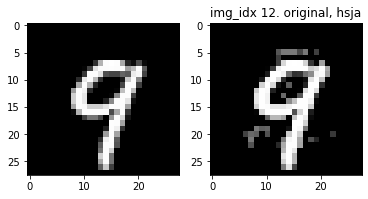

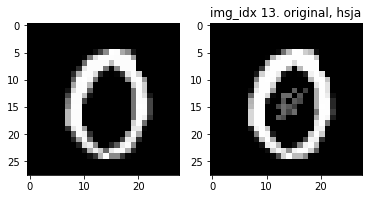

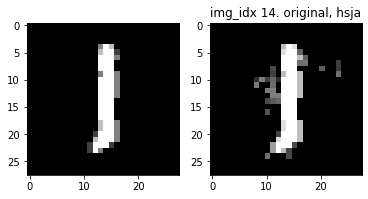

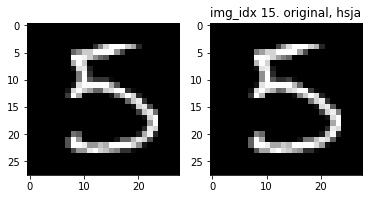

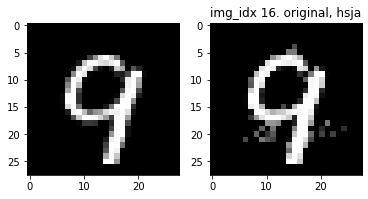

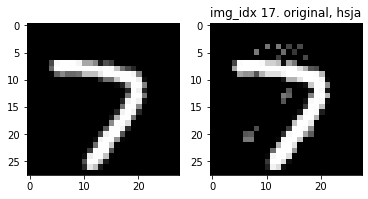

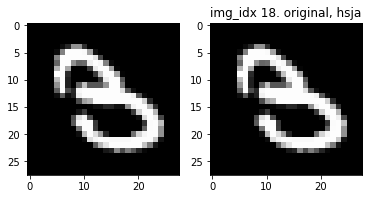

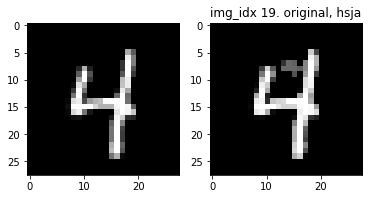

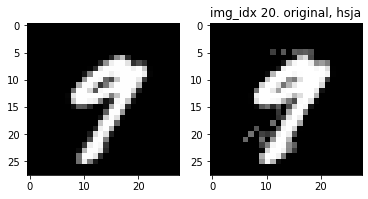

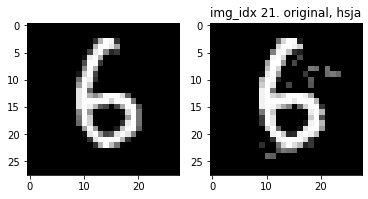

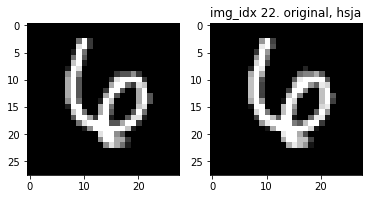

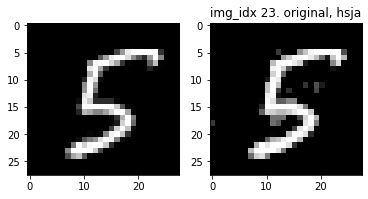

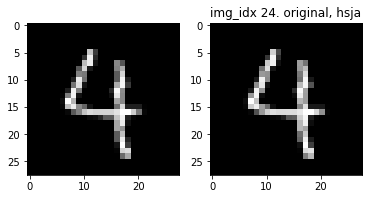

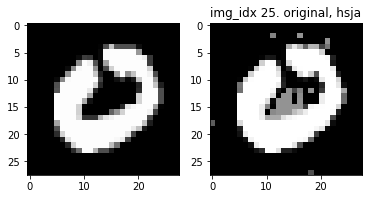

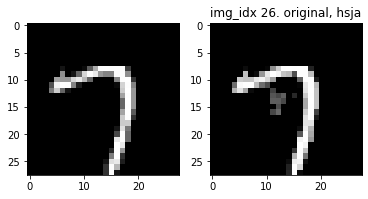

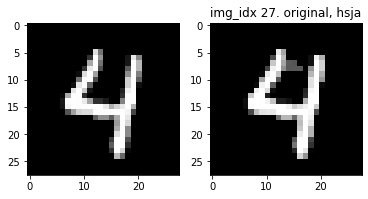

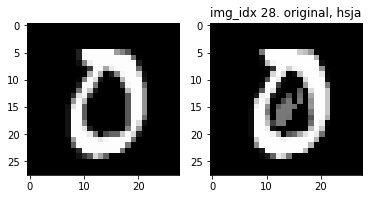

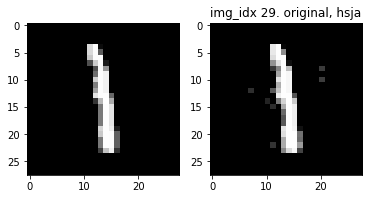

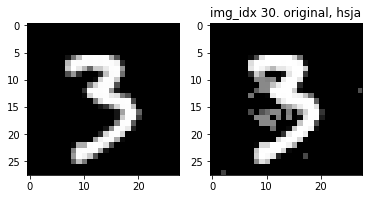

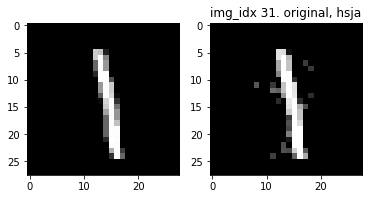

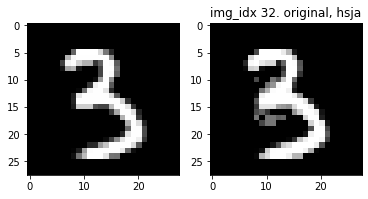

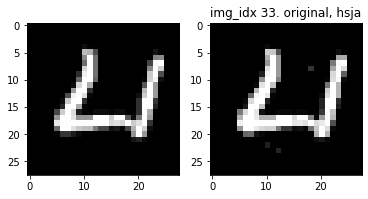

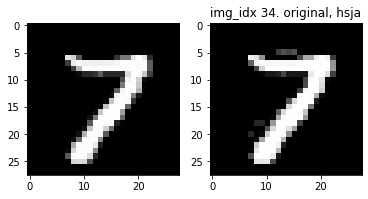

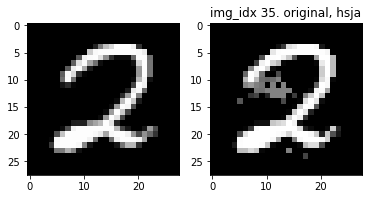

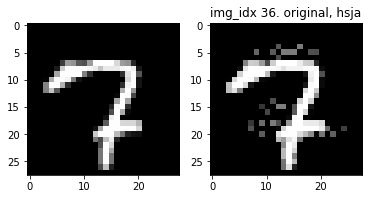

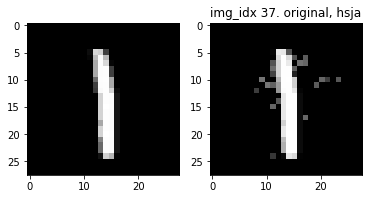

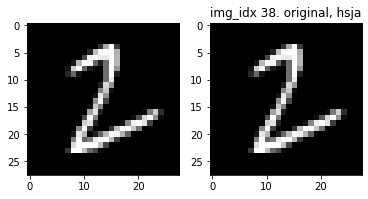

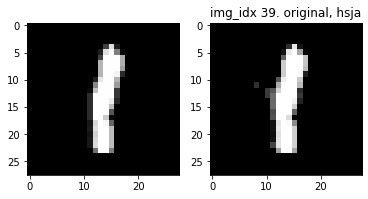

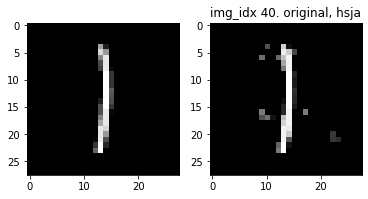

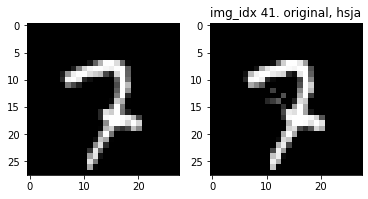

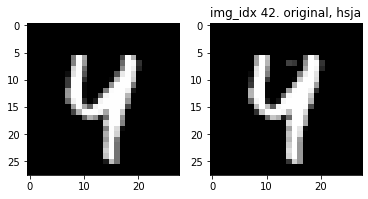

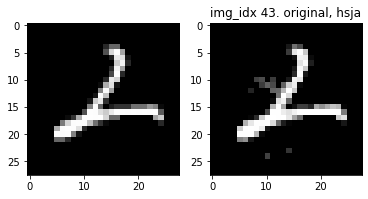

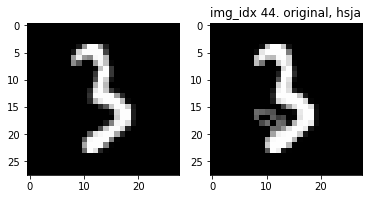

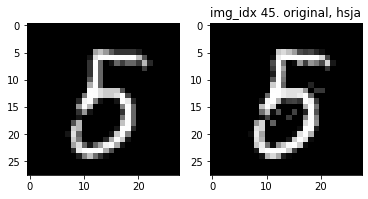

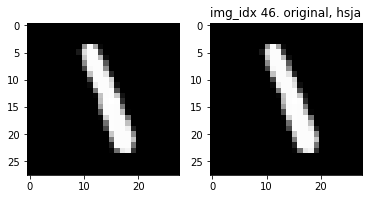

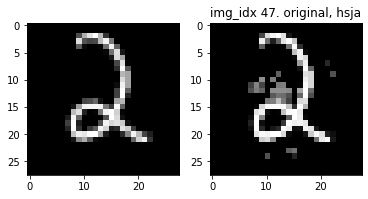

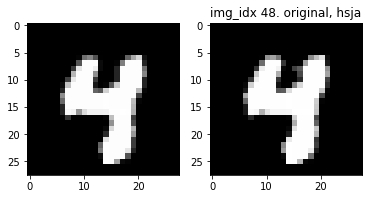

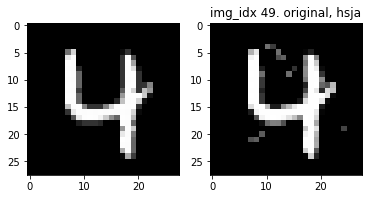

In [14]:
total = 50

org_ratio = 0
hsja_ratio = 0


org_counterexample = []
hsja_counterexample = []



for img_idx in range(0, total):
    (x, y) = torch.utils.data.Subset(dataset2, [img_idx])[0]
    
    ep = 0.0001
    
    stable_idx = all_alpha_patterns[ep][y]["stable_idx"]
    active_neurons_idx = all_alpha_patterns[ep][y]["active_neurons"]
    non_active_neurons_idx = all_alpha_patterns[ep][y]["non_active_neurons"]
    alpha_pattern = all_alpha_patterns[ep][y]["alpha_pattern"]
    
    x_extend = x[None, :]
    
    x_extend= x_extend.to(device)
    x_hsja = hop_skip_jump_attack(model, x_extend, np.inf)
   
    _, y_pred = model(x_extend).max(1)  # model prediction on clean examples
    _, y_pred_hsja= model(x_hsja).max(
        1
    )  # model prediction on FGM adversarial examples
   
    print("img_idx: {}, Predictions --- label: {}, original: {}, hsja: {}".format(img_idx, y, y_pred.item(), y_pred_hsja.item()))
    
    
    org_pattern = model.get_pattern(x_extend, layers, device, flatten = True)
    hsja_pattern = model.get_pattern(x_hsja, layers, device, flatten = True)
    
    
    org_hsja_checking = org_pattern == hsja_pattern
    
    alp_org_checking = alpha_pattern == org_pattern[:, stable_idx]
    alp_hsja_checking = alpha_pattern == hsja_pattern[:, stable_idx]
    
    print("same activation status ratio for org and hsja:", org_hsja_checking.sum()/len(org_hsja_checking[0]) )
    
    print("\n")
    
    print("label: {}, org_pred: {}".format( y, y_pred.item()))
    print("same alpha pattern for org:", alp_org_checking.sum()== len(alp_org_checking[0]), "\n" )
    print("label: {}, hsja_pred: {}".format( y, y_pred_hsja.item()))
    print("same alpha pattern for hsja:", alp_hsja_checking.sum()== len(alp_hsja_checking[0]),"\n" )

    
    if (y==y_pred.item() and alp_org_checking.sum()== len(alp_org_checking[0])) or (y!=y_pred.item() and alp_org_checking.sum()!= len(alp_org_checking[0])):
        org_ratio += 1
    else:
        org_counterexample.append(img_idx)
        
    if (y==y_pred_hsja.item() and alp_hsja_checking.sum()== len(alp_hsja_checking[0])) or (y!=y_pred_hsja.item() and alp_hsja_checking.sum()!= len(alp_hsja_checking[0])):
        hsja_ratio += 1
    else:
        hsja_counterexample.append(img_idx)
        
   
        
    print("===========")
#     figure = plt.figure()
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(x.reshape(28, 28), cmap="gray")
    axarr[1].imshow(x_hsja[0].cpu().detach().numpy().reshape(28, 28), cmap="gray")
#     plt.title("Final pred prob: {}".format(pred_prob))
    plt.title("img_idx {}. original, hsja".format(img_idx))
#     plt.close(f)

org_ratio = org_ratio / total
hsja_ratio = hsja_ratio / total

print("org pred check consistent with alpha pattern check ratio: {}\n org counter examples image idx: {}\n".format( org_ratio, org_counterexample))
print("hsja pred check consistent with alpha pattern check ratio: {}\n hsja counter examples image idx: {}\n".format( hsja_ratio, hsja_counterexample))


img_idx: 0, Predictions --- label: 7, original: 7, spsa: 7
same activation status ratio for org and spsa: 0.9716157205240175


label: 7, org_pred: 7
same alpha pattern for org: True 

label: 7, spsa_pred: 7
same alpha pattern for spsa: True 

img_idx: 1, Predictions --- label: 2, original: 2, spsa: 2
same activation status ratio for org and spsa: 0.9694323144104804


label: 2, org_pred: 2
same alpha pattern for org: True 

label: 2, spsa_pred: 2
same alpha pattern for spsa: True 

img_idx: 2, Predictions --- label: 1, original: 1, spsa: 1
same activation status ratio for org and spsa: 0.9410480349344978


label: 1, org_pred: 1
same alpha pattern for org: True 

label: 1, spsa_pred: 1
same alpha pattern for spsa: True 

img_idx: 3, Predictions --- label: 0, original: 0, spsa: 0
same activation status ratio for org and spsa: 0.9912663755458515


label: 0, org_pred: 0
same alpha pattern for org: True 

label: 0, spsa_pred: 0
same alpha pattern for spsa: True 

img_idx: 4, Predictions --- 

C:\Users\xxjtr\AppData\Local\Temp\ipykernel_2504\33460526.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(1, 2)


same activation status ratio for org and spsa: 0.9847161572052402


label: 6, org_pred: 6
same alpha pattern for org: True 

label: 6, spsa_pred: 6
same alpha pattern for spsa: True 

img_idx: 22, Predictions --- label: 6, original: 6, spsa: 6
same activation status ratio for org and spsa: 0.9847161572052402


label: 6, org_pred: 6
same alpha pattern for org: True 

label: 6, spsa_pred: 6
same alpha pattern for spsa: True 

img_idx: 23, Predictions --- label: 5, original: 5, spsa: 5
same activation status ratio for org and spsa: 0.9759825327510917


label: 5, org_pred: 5
same alpha pattern for org: True 

label: 5, spsa_pred: 5
same alpha pattern for spsa: True 

img_idx: 24, Predictions --- label: 4, original: 4, spsa: 4
same activation status ratio for org and spsa: 0.9650655021834061


label: 4, org_pred: 4
same alpha pattern for org: True 

label: 4, spsa_pred: 4
same alpha pattern for spsa: True 

img_idx: 25, Predictions --- label: 0, original: 0, spsa: 0
same activation status r

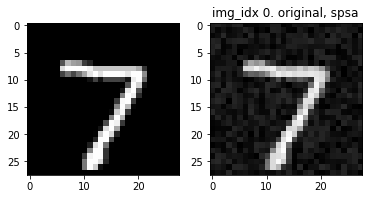

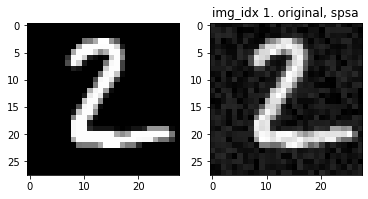

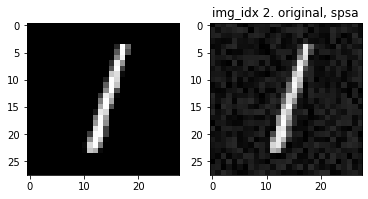

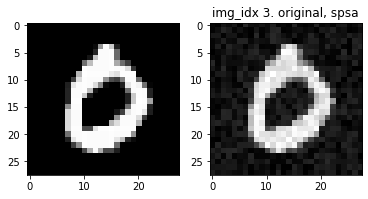

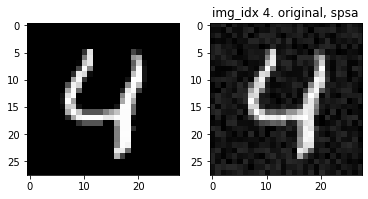

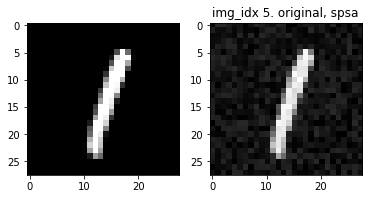

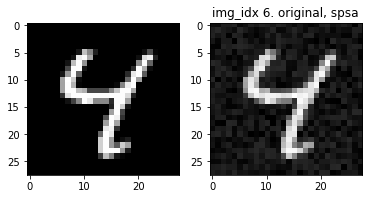

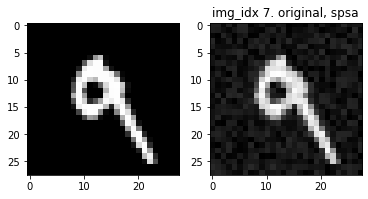

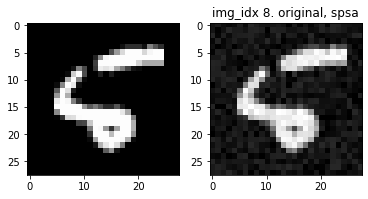

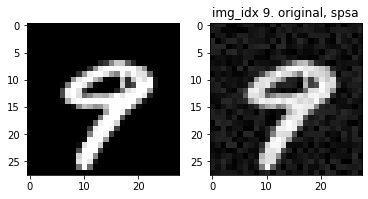

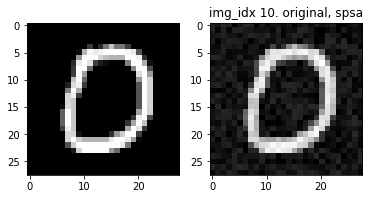

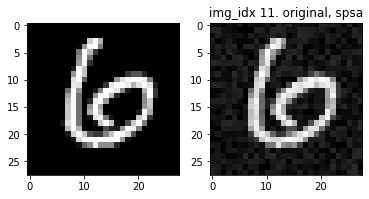

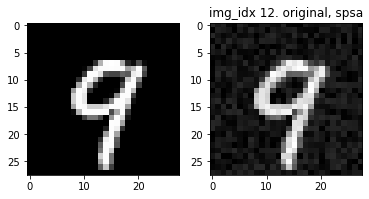

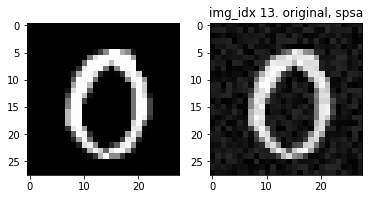

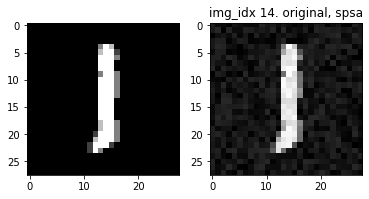

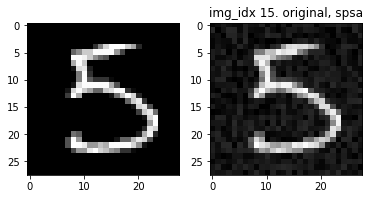

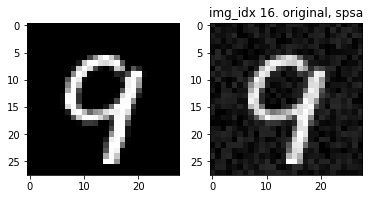

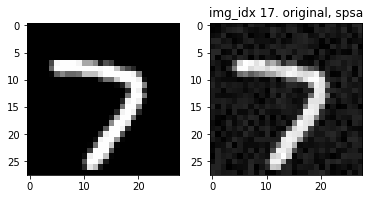

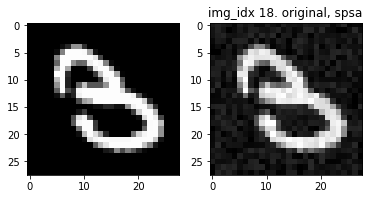

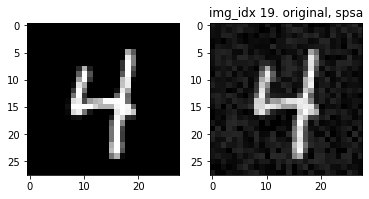

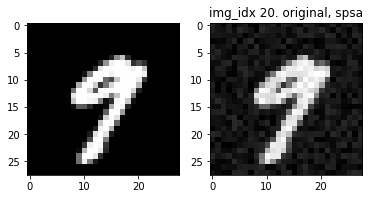

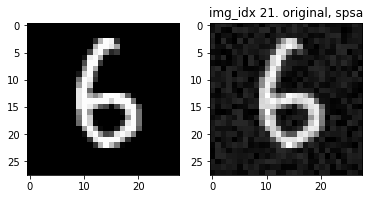

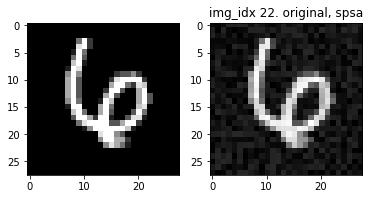

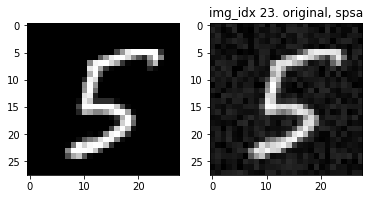

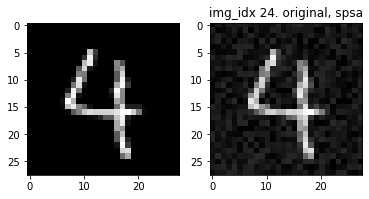

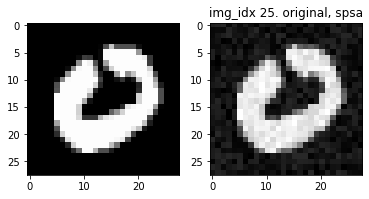

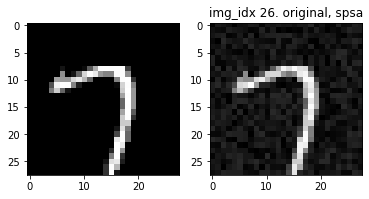

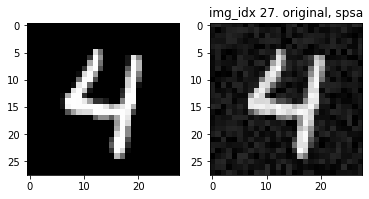

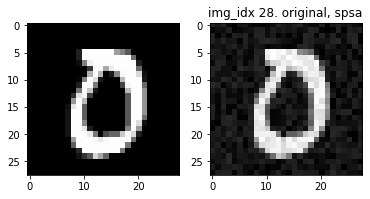

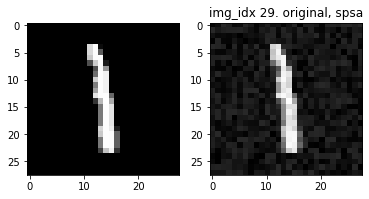

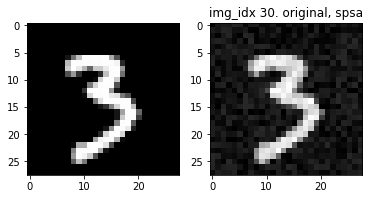

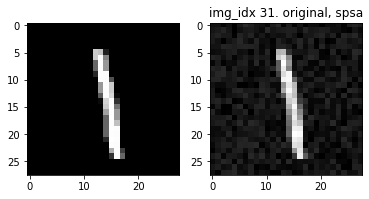

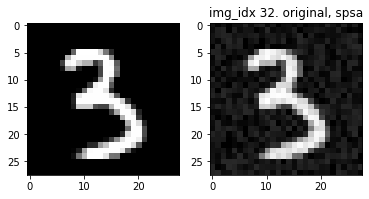

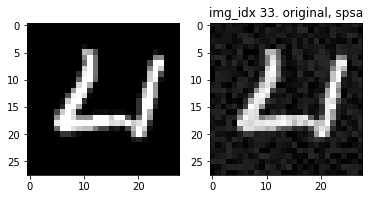

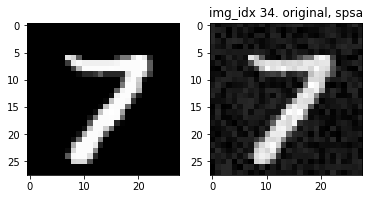

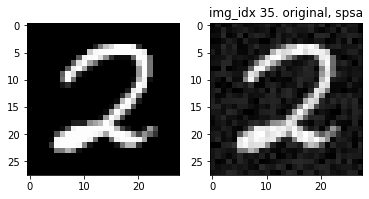

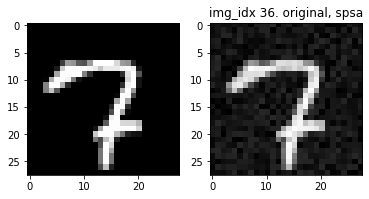

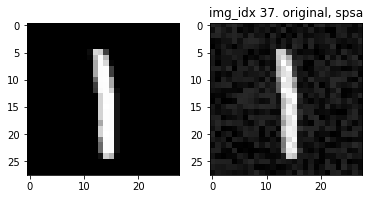

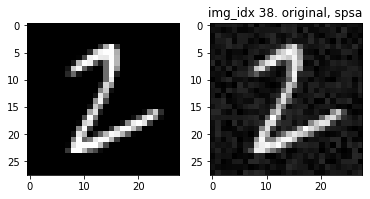

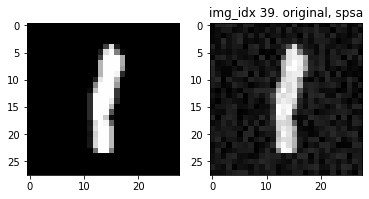

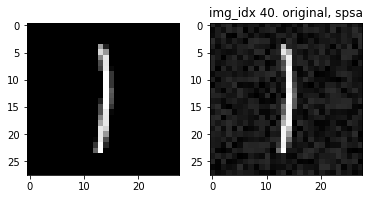

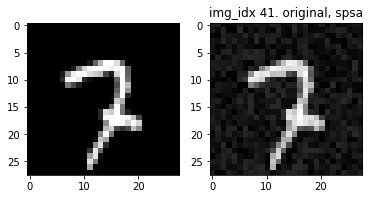

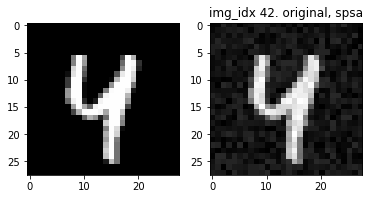

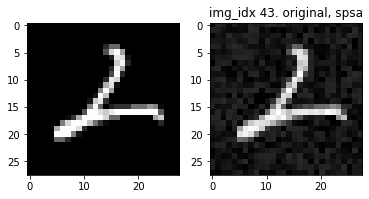

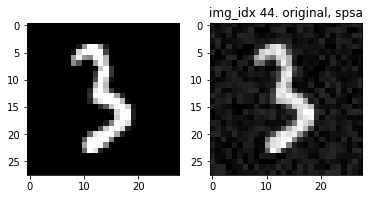

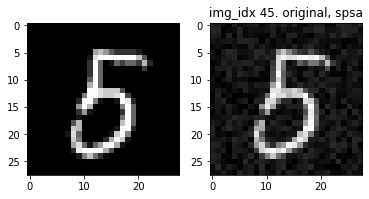

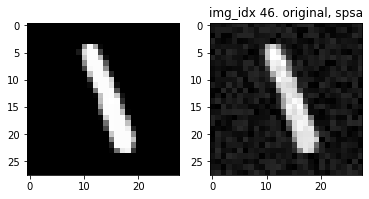

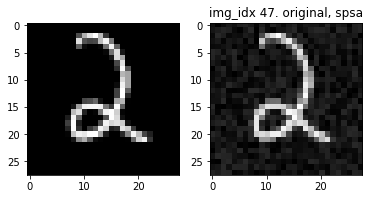

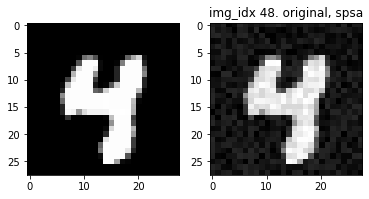

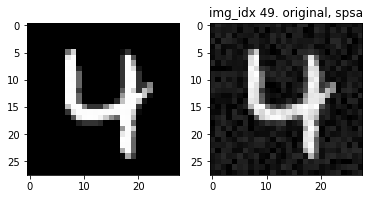

In [28]:
total = 50

org_ratio = 0
spsa_ratio = 0

org_counterexample = []
spsa_counterexample = []

for img_idx in range(0, total):
    (x, y) = torch.utils.data.Subset(dataset2, [img_idx])[0]

    ep = 0.0001

    stable_idx = all_alpha_patterns[ep][y]["stable_idx"]
    active_neurons_idx = all_alpha_patterns[ep][y]["active_neurons"]
    non_active_neurons_idx = all_alpha_patterns[ep][y]["non_active_neurons"]
    alpha_pattern = all_alpha_patterns[ep][y]["alpha_pattern"]

    x_extend = x[None, :]

    x_extend = x_extend.to(device)
    x_spsa = spsa(model.cpu(), x_extend.cpu(), 0.3, 8).to(device)
    
    model.to(device)

    _, y_pred = model(x_extend).max(1)  # model prediction on clean examples
    _, y_pred_spsa = model(x_spsa).max(
        1
    )  # model prediction on FGM adversarial examples

    print("img_idx: {}, Predictions --- label: {}, original: {}, spsa: {}".format(img_idx, y, y_pred.item(),
                                                                                  y_pred_spsa.item()))

    org_pattern = model.get_pattern(x_extend, layers, device, flatten=True)
    spsa_pattern = model.get_pattern(x_spsa, layers, device, flatten=True)

    org_spsa_checking = org_pattern == spsa_pattern

    alp_org_checking = alpha_pattern == org_pattern[:, stable_idx]
    alp_spsa_checking = alpha_pattern == spsa_pattern[:, stable_idx]

    print("same activation status ratio for org and spsa:", org_spsa_checking.sum() / len(org_spsa_checking[0]))

    print("\n")

    print("label: {}, org_pred: {}".format(y, y_pred.item()))
    print("same alpha pattern for org:", alp_org_checking.sum() == len(alp_org_checking[0]), "\n")
    print("label: {}, spsa_pred: {}".format(y, y_pred_spsa.item()))
    print("same alpha pattern for spsa:", alp_spsa_checking.sum() == len(alp_spsa_checking[0]), "\n")

    if (y == y_pred.item() and alp_org_checking.sum() == len(alp_org_checking[0])) or (
            y != y_pred.item() and alp_org_checking.sum() != len(alp_org_checking[0])):
        org_ratio += 1
    else:
        org_counterexample.append(img_idx)

    if (y == y_pred_spsa.item() and alp_spsa_checking.sum() == len(alp_spsa_checking[0])) or (
            y != y_pred_spsa.item() and alp_spsa_checking.sum() != len(alp_spsa_checking[0])):
        spsa_ratio += 1
    else:
        spsa_counterexample.append(img_idx)

    print("===========")
    #     figure = plt.figure()
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(x.reshape(28, 28), cmap="gray")
    axarr[1].imshow(x_spsa[0].cpu().detach().numpy().reshape(28, 28), cmap="gray")
    #     plt.title("Final pred prob: {}".format(pred_prob))
    plt.title("img_idx {}. original, spsa".format(img_idx))
#     plt.close(f)

org_ratio = org_ratio / total
spsa_ratio = spsa_ratio / total

print("org pred check consistent with alpha pattern check ratio: {}\n org counter examples image idx: {}\n".format(
    org_ratio, org_counterexample))
print("spsa pred check consistent with alpha pattern check ratio: {}\n spsa counter examples image idx: {}\n".format(
    spsa_ratio, spsa_counterexample))

img_idx: 0, Predictions --- label: 7, original: 7, cwl2: 9
same activation status ratio for org and cwl2: 0.851528384279476


label: 7, org_pred: 7
same alpha pattern for org: True 

label: 7, cwl2_pred: 9
same alpha pattern for cwl2: False 

img_idx: 1, Predictions --- label: 2, original: 2, cwl2: 3
same activation status ratio for org and cwl2: 0.9126637554585153


label: 2, org_pred: 2
same alpha pattern for org: True 

label: 2, cwl2_pred: 3
same alpha pattern for cwl2: False 

img_idx: 2, Predictions --- label: 1, original: 1, cwl2: 2
same activation status ratio for org and cwl2: 0.8318777292576419


label: 1, org_pred: 1
same alpha pattern for org: True 

label: 1, cwl2_pred: 2
same alpha pattern for cwl2: False 

img_idx: 3, Predictions --- label: 0, original: 0, cwl2: 2
same activation status ratio for org and cwl2: 0.925764192139738


label: 0, org_pred: 0
same alpha pattern for org: True 

label: 0, cwl2_pred: 2
same alpha pattern for cwl2: False 

img_idx: 4, Predictions --

C:\Users\xxjtr\AppData\Local\Temp\ipykernel_2504\3729685010.py:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(1, 2)


img_idx: 21, Predictions --- label: 6, original: 6, cwl2: 8
same activation status ratio for org and cwl2: 0.8864628820960698


label: 6, org_pred: 6
same alpha pattern for org: True 

label: 6, cwl2_pred: 8
same alpha pattern for cwl2: False 

img_idx: 22, Predictions --- label: 6, original: 6, cwl2: 2
same activation status ratio for org and cwl2: 0.8951965065502183


label: 6, org_pred: 6
same alpha pattern for org: True 

label: 6, cwl2_pred: 2
same alpha pattern for cwl2: False 

img_idx: 23, Predictions --- label: 5, original: 5, cwl2: 8
same activation status ratio for org and cwl2: 0.9148471615720524


label: 5, org_pred: 5
same alpha pattern for org: True 

label: 5, cwl2_pred: 8
same alpha pattern for cwl2: False 

img_idx: 24, Predictions --- label: 4, original: 4, cwl2: 9
same activation status ratio for org and cwl2: 0.8602620087336245


label: 4, org_pred: 4
same alpha pattern for org: True 

label: 4, cwl2_pred: 9
same alpha pattern for cwl2: False 

img_idx: 25, Predict

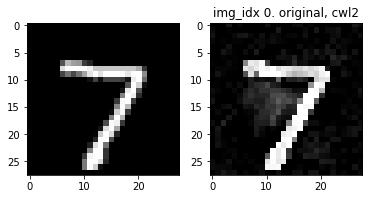

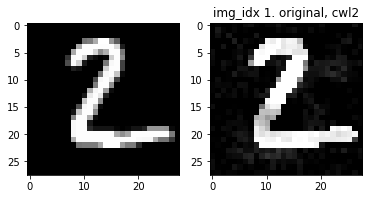

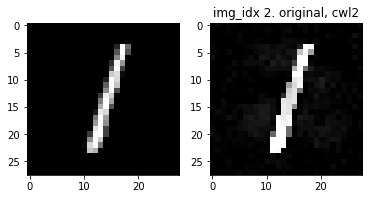

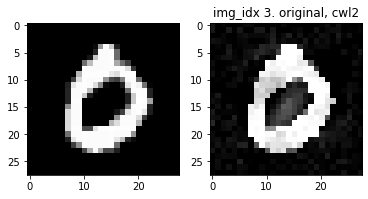

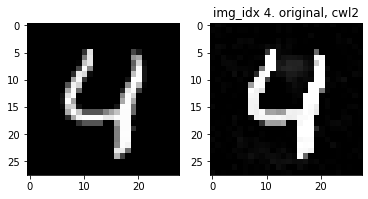

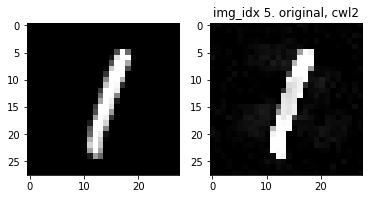

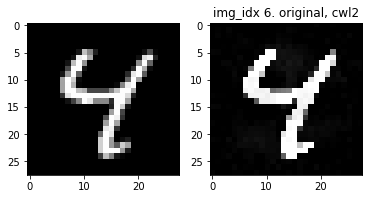

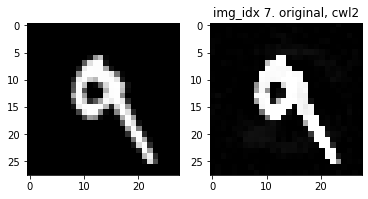

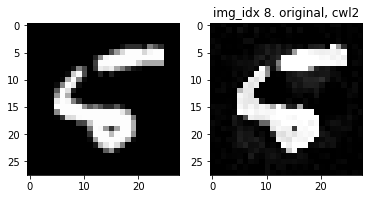

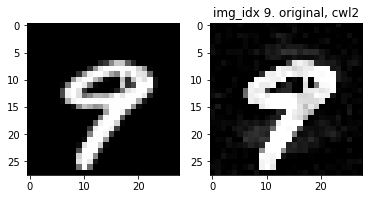

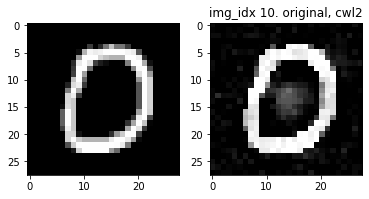

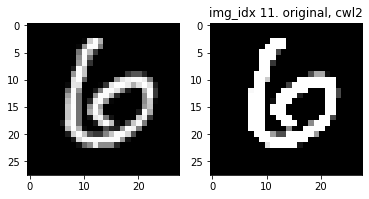

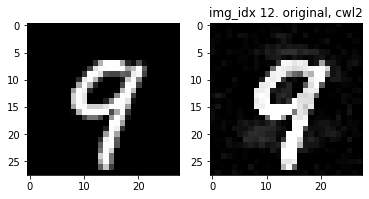

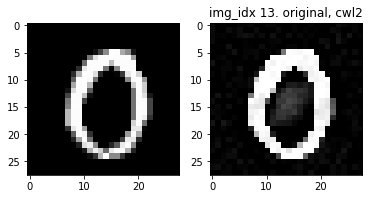

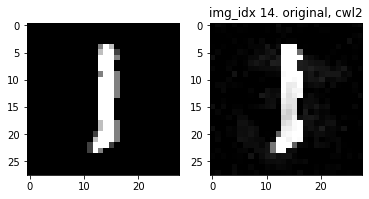

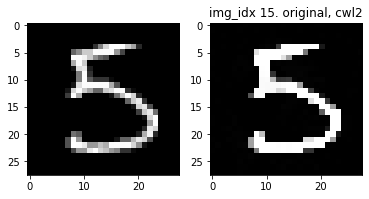

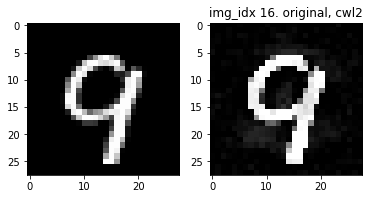

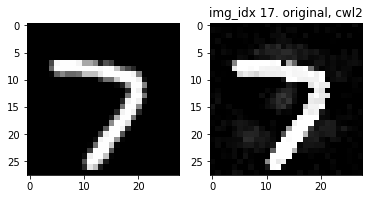

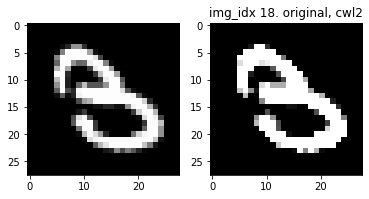

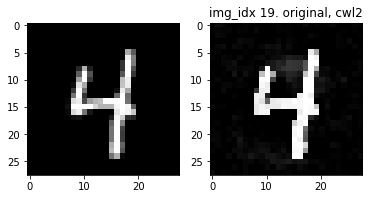

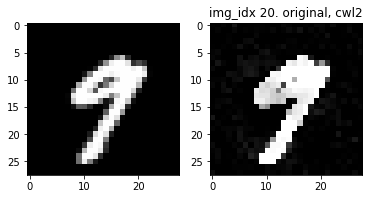

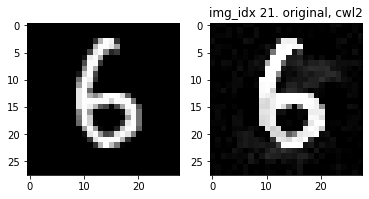

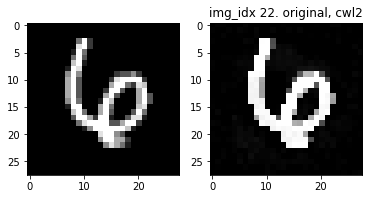

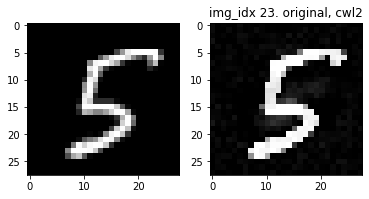

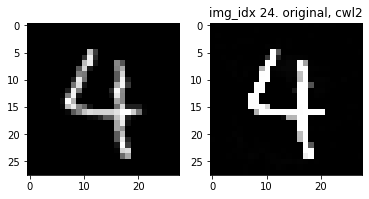

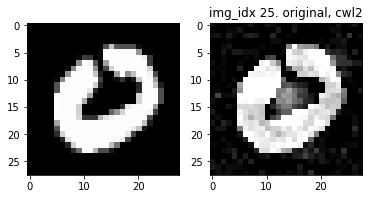

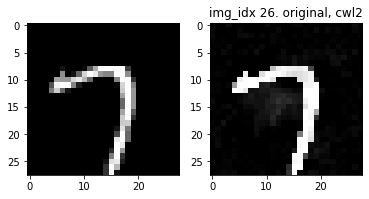

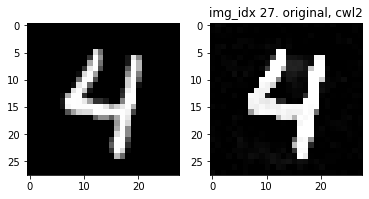

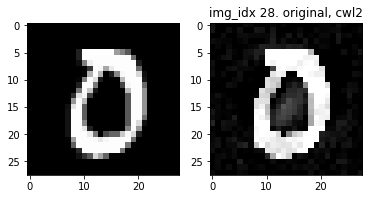

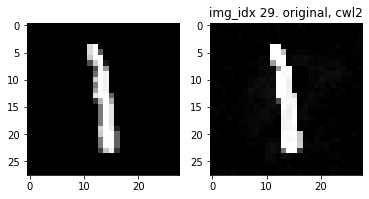

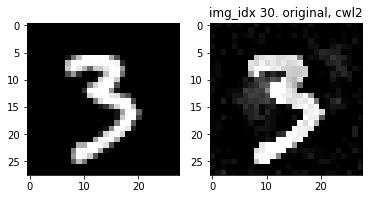

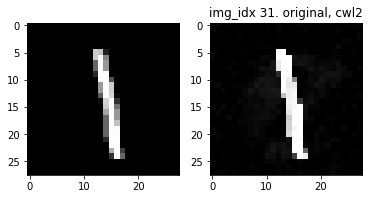

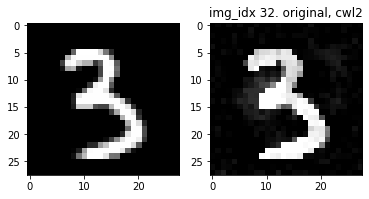

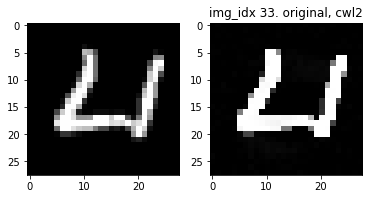

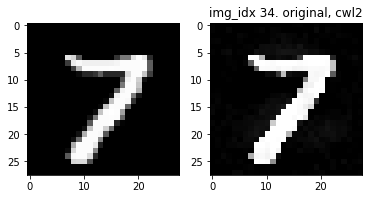

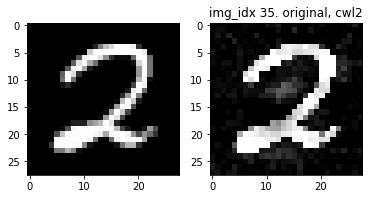

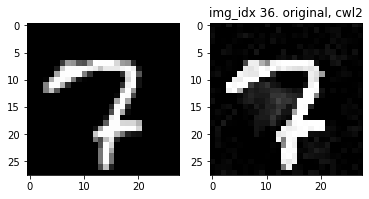

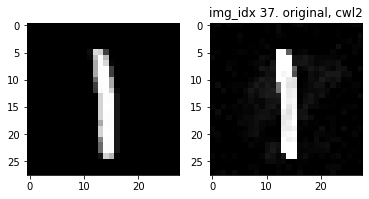

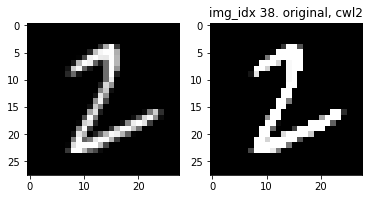

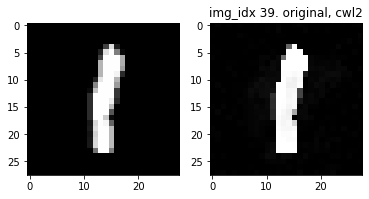

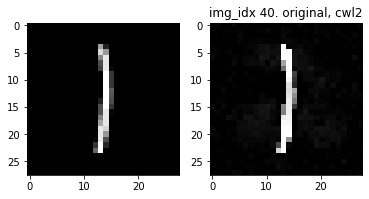

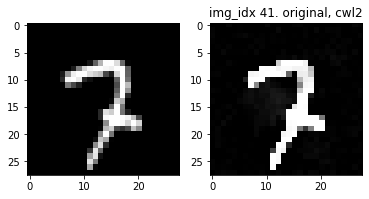

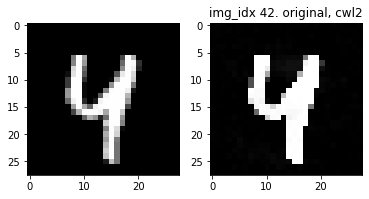

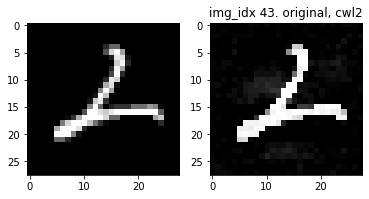

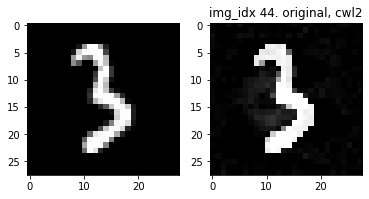

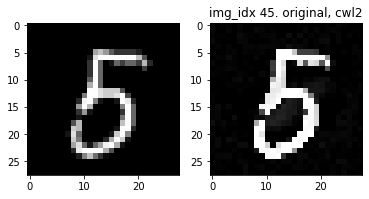

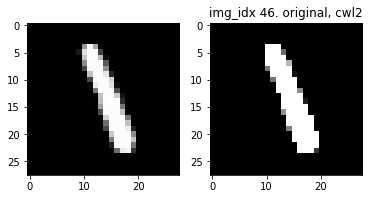

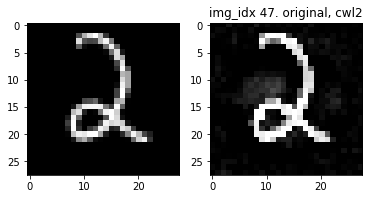

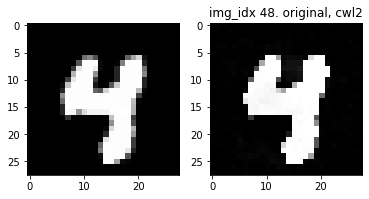

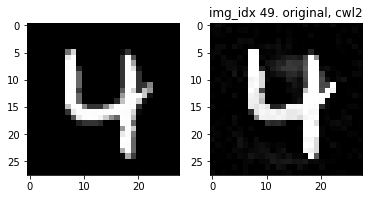

In [19]:
total = 50

org_ratio = 0
cwl2_ratio = 0

org_counterexample = []
cwl2_counterexample = []

for img_idx in range(0, total):
    (x, y) = torch.utils.data.Subset(dataset2, [img_idx])[0]

    ep = 0.0001

    stable_idx = all_alpha_patterns[ep][y]["stable_idx"]
    active_neurons_idx = all_alpha_patterns[ep][y]["active_neurons"]
    non_active_neurons_idx = all_alpha_patterns[ep][y]["non_active_neurons"]
    alpha_pattern = all_alpha_patterns[ep][y]["alpha_pattern"]

    x_extend = x[None, :]

    x_extend = x_extend.to(device)
    x_cwl2 = carlini_wagner_l2(model, x_extend, 10)

    _, y_pred = model(x_extend).max(1)  # model prediction on clean examples
    _, y_pred_cwl2 = model(x_cwl2).max(
        1
    )  # model prediction on FGM adversarial examples

    print("img_idx: {}, Predictions --- label: {}, original: {}, cwl2: {}".format(img_idx, y, y_pred.item(),
                                                                                  y_pred_cwl2.item()))

    org_pattern = model.get_pattern(x_extend, layers, device, flatten=True)
    cwl2_pattern = model.get_pattern(x_cwl2, layers, device, flatten=True)

    org_cwl2_checking = org_pattern == cwl2_pattern

    alp_org_checking = alpha_pattern == org_pattern[:, stable_idx]
    alp_cwl2_checking = alpha_pattern == cwl2_pattern[:, stable_idx]

    print("same activation status ratio for org and cwl2:", org_cwl2_checking.sum() / len(org_cwl2_checking[0]))

    print("\n")

    print("label: {}, org_pred: {}".format(y, y_pred.item()))
    print("same alpha pattern for org:", alp_org_checking.sum() == len(alp_org_checking[0]), "\n")
    print("label: {}, cwl2_pred: {}".format(y, y_pred_cwl2.item()))
    print("same alpha pattern for cwl2:", alp_cwl2_checking.sum() == len(alp_cwl2_checking[0]), "\n")

    if (y == y_pred.item() and alp_org_checking.sum() == len(alp_org_checking[0])) or (
            y != y_pred.item() and alp_org_checking.sum() != len(alp_org_checking[0])):
        org_ratio += 1
    else:
        org_counterexample.append(img_idx)

    if (y == y_pred_cwl2.item() and alp_cwl2_checking.sum() == len(alp_cwl2_checking[0])) or (
            y != y_pred_cwl2.item() and alp_cwl2_checking.sum() != len(alp_cwl2_checking[0])):
        cwl2_ratio += 1
    else:
        cwl2_counterexample.append(img_idx)

    print("===========")
    #     figure = plt.figure()
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(x.reshape(28, 28), cmap="gray")
    axarr[1].imshow(x_cwl2[0].cpu().detach().numpy().reshape(28, 28), cmap="gray")
    #     plt.title("Final pred prob: {}".format(pred_prob))
    plt.title("img_idx {}. original, cwl2".format(img_idx))
#     plt.close(f)

org_ratio = org_ratio / total
cwl2_ratio = cwl2_ratio / total

print("org pred check consistent with alpha pattern check ratio: {}\n org counter examples image idx: {}\n".format(
    org_ratio, org_counterexample))
print("cwl2 pred check consistent with alpha pattern check ratio: {}\n cwl2 counter examples image idx: {}\n".format(
    cwl2_ratio, cwl2_counterexample))

img_idx: 0, Predictions --- label: 7, original: 7, sl1d: 7
same activation status ratio for org and sl1d: 0.962882096069869


label: 7, org_pred: 7
same alpha pattern for org: True 

label: 7, sl1d_pred: 7
same alpha pattern for sl1d: True 

img_idx: 1, Predictions --- label: 2, original: 2, sl1d: 2
same activation status ratio for org and sl1d: 0.980349344978166


label: 2, org_pred: 2
same alpha pattern for org: True 

label: 2, sl1d_pred: 2
same alpha pattern for sl1d: True 

img_idx: 2, Predictions --- label: 1, original: 1, sl1d: 1
same activation status ratio for org and sl1d: 0.9410480349344978


label: 1, org_pred: 1
same alpha pattern for org: True 

label: 1, sl1d_pred: 1
same alpha pattern for sl1d: True 

img_idx: 3, Predictions --- label: 0, original: 0, sl1d: 0
same activation status ratio for org and sl1d: 0.9868995633187773


label: 0, org_pred: 0
same alpha pattern for org: True 

label: 0, sl1d_pred: 0
same alpha pattern for sl1d: True 

img_idx: 4, Predictions --- la

C:\Users\xxjtr\AppData\Local\Temp\ipykernel_2504\4005406679.py:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(1, 2)


img_idx: 22, Predictions --- label: 6, original: 6, sl1d: 6
same activation status ratio for org and sl1d: 0.9847161572052402


label: 6, org_pred: 6
same alpha pattern for org: True 

label: 6, sl1d_pred: 6
same alpha pattern for sl1d: True 

img_idx: 23, Predictions --- label: 5, original: 5, sl1d: 5
same activation status ratio for org and sl1d: 0.9847161572052402


label: 5, org_pred: 5
same alpha pattern for org: True 

label: 5, sl1d_pred: 5
same alpha pattern for sl1d: True 

img_idx: 24, Predictions --- label: 4, original: 4, sl1d: 4
same activation status ratio for org and sl1d: 0.9519650655021834


label: 4, org_pred: 4
same alpha pattern for org: True 

label: 4, sl1d_pred: 4
same alpha pattern for sl1d: True 

img_idx: 25, Predictions --- label: 0, original: 0, sl1d: 0
same activation status ratio for org and sl1d: 0.9890829694323144


label: 0, org_pred: 0
same alpha pattern for org: True 

label: 0, sl1d_pred: 0
same alpha pattern for sl1d: True 

img_idx: 26, Predictions

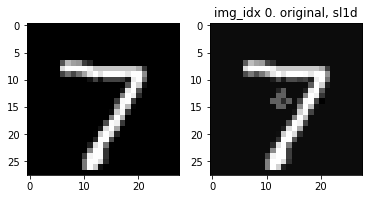

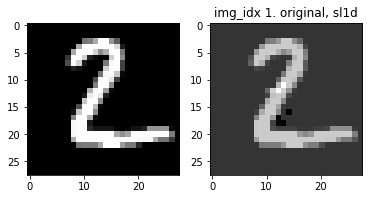

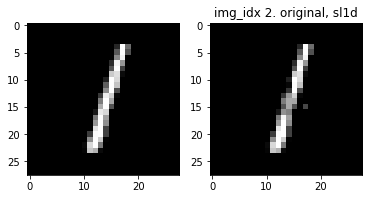

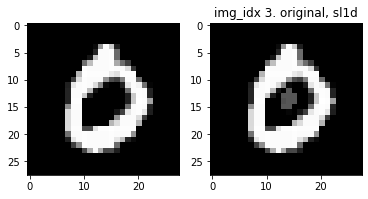

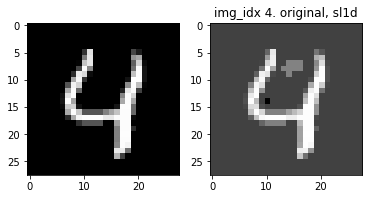

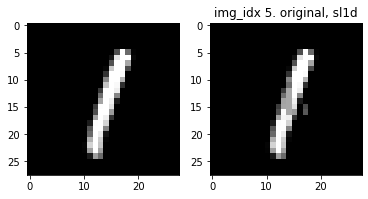

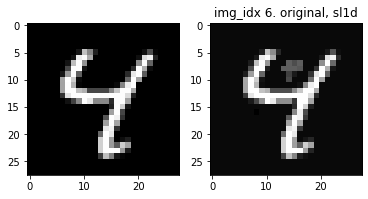

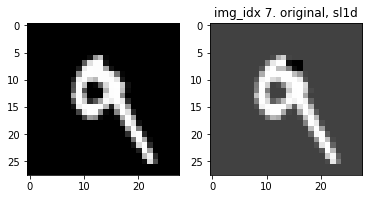

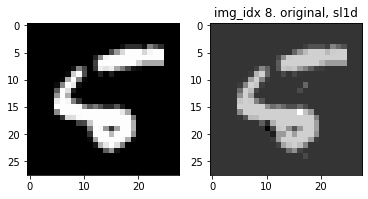

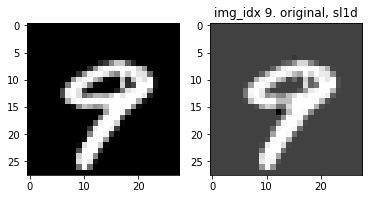

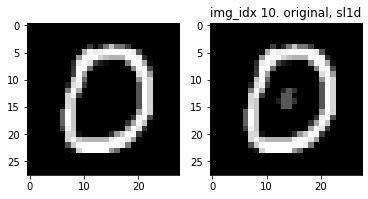

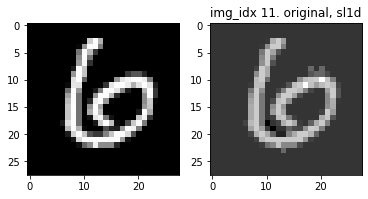

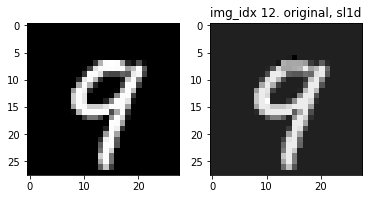

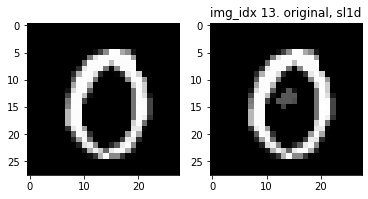

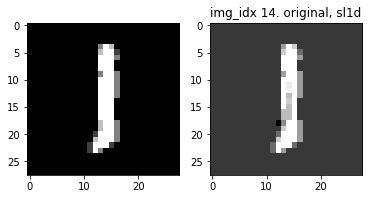

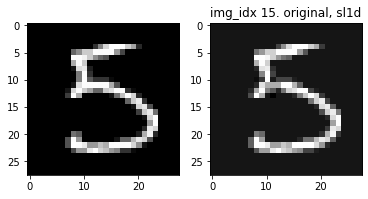

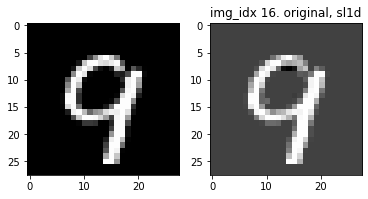

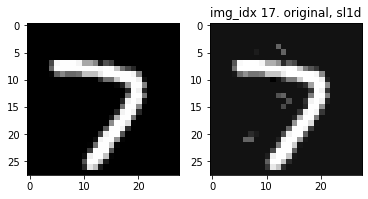

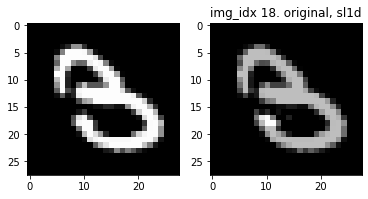

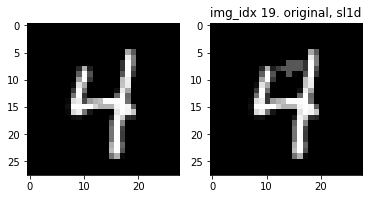

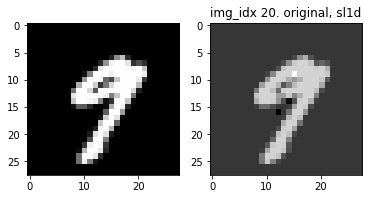

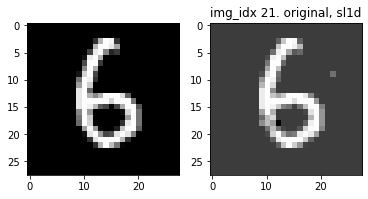

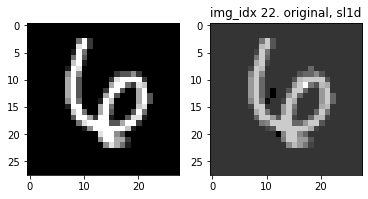

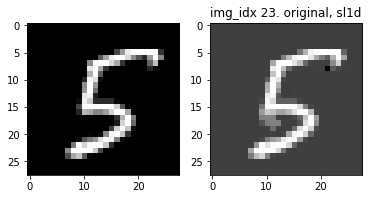

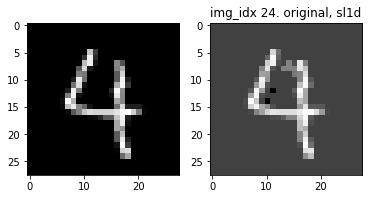

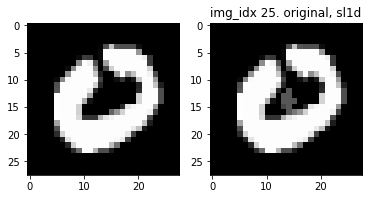

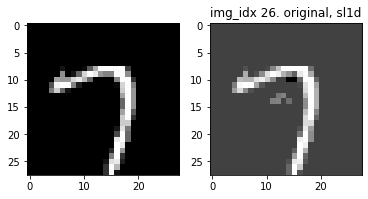

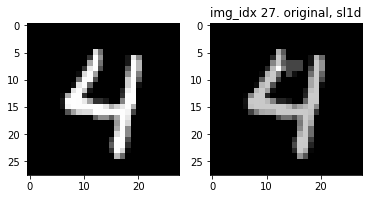

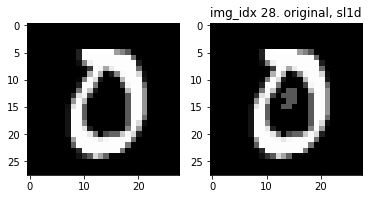

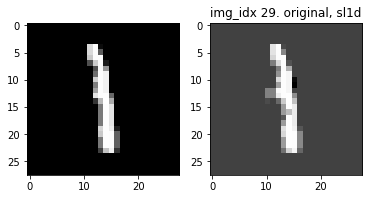

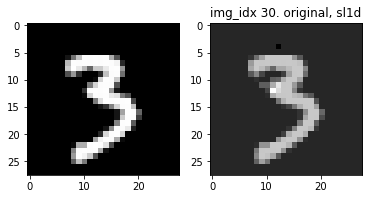

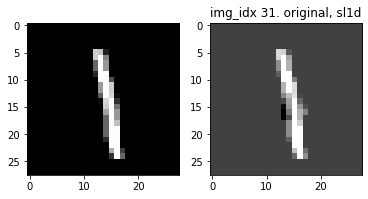

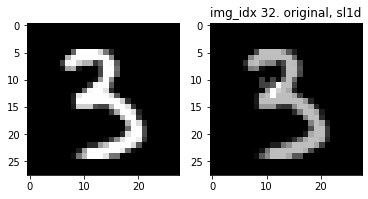

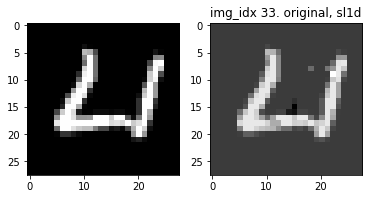

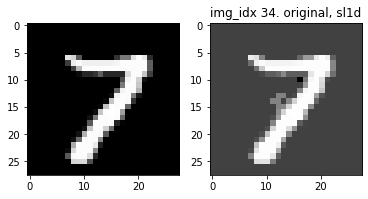

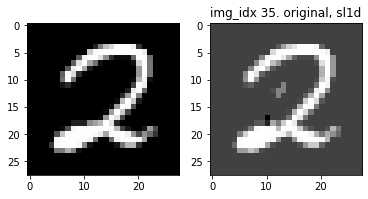

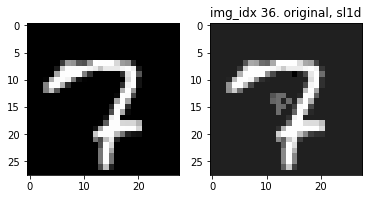

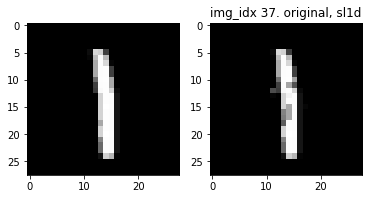

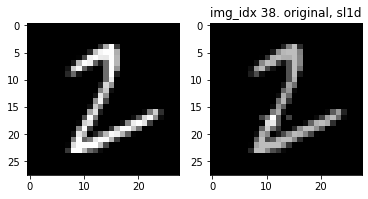

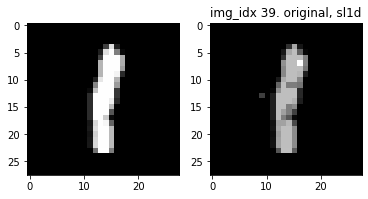

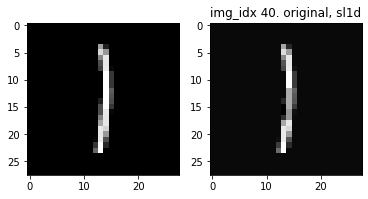

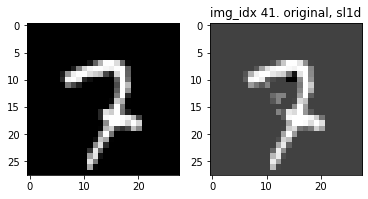

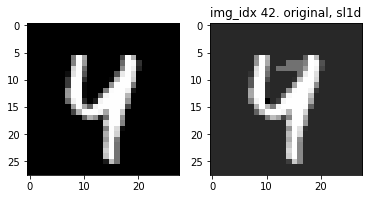

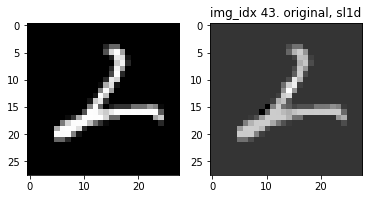

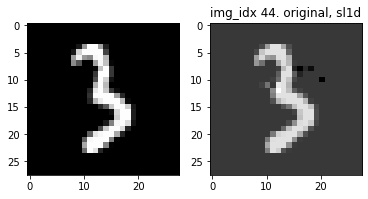

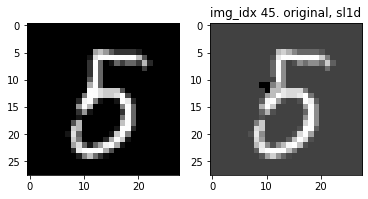

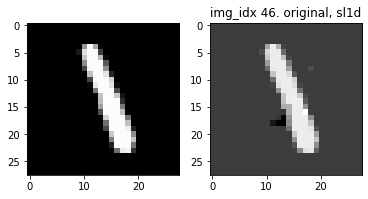

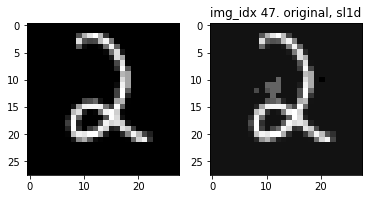

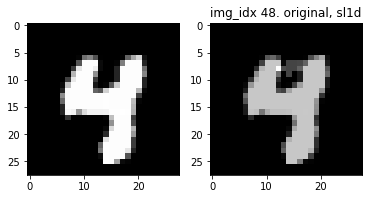

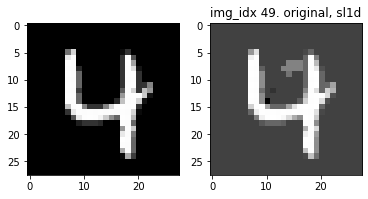

In [22]:
total = 50

org_ratio = 0
sl1d_ratio = 0

org_counterexample = []
sl1d_counterexample = []

for img_idx in range(0, total):
    (x, y) = torch.utils.data.Subset(dataset2, [img_idx])[0]

    ep = 0.0001

    stable_idx = all_alpha_patterns[ep][y]["stable_idx"]
    active_neurons_idx = all_alpha_patterns[ep][y]["active_neurons"]
    non_active_neurons_idx = all_alpha_patterns[ep][y]["non_active_neurons"]
    alpha_pattern = all_alpha_patterns[ep][y]["alpha_pattern"]

    x_extend = x[None, :]

    x_extend = x_extend.to(device)
    x_sl1d = sparse_l1_descent(model, x_extend)

    _, y_pred = model(x_extend).max(1)  # model prediction on clean examples
    _, y_pred_sl1d = model(x_sl1d).max(
        1
    )  # model prediction on FGM adversarial examples

    print("img_idx: {}, Predictions --- label: {}, original: {}, sl1d: {}".format(img_idx, y, y_pred.item(),
                                                                                  y_pred_sl1d.item()))

    org_pattern = model.get_pattern(x_extend, layers, device, flatten=True)
    sl1d_pattern = model.get_pattern(x_sl1d, layers, device, flatten=True)

    org_sl1d_checking = org_pattern == sl1d_pattern

    alp_org_checking = alpha_pattern == org_pattern[:, stable_idx]
    alp_sl1d_checking = alpha_pattern == sl1d_pattern[:, stable_idx]

    print("same activation status ratio for org and sl1d:", org_sl1d_checking.sum() / len(org_sl1d_checking[0]))

    print("\n")

    print("label: {}, org_pred: {}".format(y, y_pred.item()))
    print("same alpha pattern for org:", alp_org_checking.sum() == len(alp_org_checking[0]), "\n")
    print("label: {}, sl1d_pred: {}".format(y, y_pred_sl1d.item()))
    print("same alpha pattern for sl1d:", alp_sl1d_checking.sum() == len(alp_sl1d_checking[0]), "\n")

    if (y == y_pred.item() and alp_org_checking.sum() == len(alp_org_checking[0])) or (
            y != y_pred.item() and alp_org_checking.sum() != len(alp_org_checking[0])):
        org_ratio += 1
    else:
        org_counterexample.append(img_idx)

    if (y == y_pred_sl1d.item() and alp_sl1d_checking.sum() == len(alp_sl1d_checking[0])) or (
            y != y_pred_sl1d.item() and alp_sl1d_checking.sum() != len(alp_sl1d_checking[0])):
        sl1d_ratio += 1
    else:
        sl1d_counterexample.append(img_idx)

    print("===========")
    #     figure = plt.figure()
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(x.reshape(28, 28), cmap="gray")
    axarr[1].imshow(x_sl1d[0].cpu().detach().numpy().reshape(28, 28), cmap="gray")
    #     plt.title("Final pred prob: {}".format(pred_prob))
    plt.title("img_idx {}. original, sl1d".format(img_idx))
#     plt.close(f)

org_ratio = org_ratio / total
sl1d_ratio = sl1d_ratio / total

print("org pred check consistent with alpha pattern check ratio: {}\n org counter examples image idx: {}\n".format(
    org_ratio, org_counterexample))
print("sl1d pred check consistent with alpha pattern check ratio: {}\n sl1d counter examples image idx: {}\n".format(
    sl1d_ratio, sl1d_counterexample))

In [2]:
# import json
# # LOAD THE AVED ALPHA PATTERNS
# LOAD_PATTERNS = True
# PATTERN_PATH = "relu_exp_data02-20-19.json"
# if LOAD_PATTERNS:
    
#     # Opening JSON file
#     f = open(PATTERN_PATH)

#     # returns JSON object as 
#     # a dictionary
#     data = json.load(f)

#     f.close()
#     print(data)

{'model': 'FFN18_28_21', '0.0001': {'0': {'stable_idx': [19, 70, 142, 238, 257, 258, 259, 260, 265, 267, 275, 285, 287, 288, 295, 302, 307, 323, 329, 338, 339, 340, 343, 346, 347, 349, 352, 360, 365, 369, 374, 375, 380, 392, 396, 401, 403, 406, 414, 417, 418, 420, 423, 424, 426, 429, 434, 448, 449], 'active_neurons': [19, 70, 142, 238, 258, 259, 260, 265, 275, 285, 287, 295, 302, 307, 323, 329, 339, 340, 346, 347, 349, 352, 360, 365, 369, 380, 396, 406, 417, 420, 423, 424, 426, 429, 434], 'non_active_neurons': [257, 267, 288, 338, 343, 374, 375, 392, 401, 403, 414, 418, 449], 'alpha_pattern': [True, True, True, True, False, True, True, True, True, False, True, True, True, False, True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, False, False, True, False, True, False, False, True, False, True, False, True, True, True, True, True, True, True, False], 'alpha_pattern_coverage': 0.95981765996961, 'pattern_frequency': [238, 5685]}, '1': {'stabl